In [3]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

# Analysis
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')

# Import Ngl with pyn_env active 
# import Ngl



In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


In [3]:
'''
Define a function to get the height of the PBL as the level with maximum d(var)/dz. 
Inputs:  A dataset with CAM output ('DS') and the variable to differentiate ('pbl_var')
Outputs: An array with boundary layer depth
'''
def PBLHasMaxDZ(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(dvardz[iT,iLevs]==np.nanmax(dvardz[iT,iLevs]))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

In [7]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values[0]/100        # mb

    # Pull out hya/hyb profiles 
    hyam = DS.hyam.values[0,:]
    hybm = DS.hybm.values[0,:]
    hyai = DS.hyai.values[0,:]
    hybi = DS.hybi.values[0,:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut


# Read in data & process it as before (after a quick peak at some plots)

In [8]:
# ## Where files are saved + start of casename
# dataDir = '/glade/scratch/mdfowler/archive/'

# htgFileStart = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'
# hmgFileStart = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens'

# ## Extra vars I want, but they're on the h0 files instead of the h1 files (same time step, just different stream) 
# addVars = np.asarray(['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
#                       'U10','CLDHGH','CLDLIQ','TMQ'])

# ## Other settings to build up case names 
# pertVals = np.asarray(['05'])

# dayArr   = np.asarray(['01,05,09,13,17,21,25,29,03,07,11,15,19,23,27,31,04,08,12,16,20,24,28']).astype(str)
# monArr   = np.asarray(['06,06,06,06,06,06,06,06,07,07,07,07,07,07,07,07,08,08,08,08,08,08,08']).astype(str)

# days   = np.char.split(dayArr,',')[0]
# months = np.char.split(monArr,',')[0]
# years  = np.asarray(['2015','2016','2017','2018'])

# pertCount = 0
# for iPert in range(len(pertVals)): 

#     fileCount = 0
#     for iYr in range(len(years)):
#         print('Starting year ',years[iYr])
        
#         hmgCaseBase = dataDir+hmgFileStart+years[iYr]+'_start'
#         htgCaseBase = dataDir+htgFileStart+years[iYr]+'_start'
        
#         for iDay in range(len(days)):
#             # hmgCaseName = dataDir+hmgFileStart+months[iDay]+days[iDay]+'_pert'+pertVals[iPert]
#             # htgCaseName = dataDir+htgFileStart+months[iDay]+days[iDay]+'_pert'+pertVals[iPert]
#             hmgCaseName = hmgCaseBase+months[iDay]+days[iDay]+'_pert'+pertVals[iPert]
#             htgCaseName = htgCaseBase+months[iDay]+days[iDay]+'_pert'+pertVals[iPert]

#             ## Get list of files within each (pertlim) case 
#             listFilesHMG_camh1 = np.sort(glob.glob(hmgCaseName+'/atm/hist/*h1*'))
#             listFilesHMG_camh0 = np.sort(glob.glob(hmgCaseName+'/atm/hist/*h0*'))

#             listFilesHTG_camh1 = np.sort(glob.glob(htgCaseName+'/atm/hist/*h1*'))
#             listFilesHTG_camh0 = np.sort(glob.glob(htgCaseName+'/atm/hist/*h0*'))

#             listFilesHMG_clmh0 = np.sort(glob.glob(hmgCaseName+'/lnd/hist/*h0*'))
#             listFilesHTG_clmh0 = np.sort(glob.glob(htgCaseName+'/lnd/hist/*h0*'))

#             ## Loop over files and read into larger case array 
#             # print('*** Upsampling to 30m means ***')
#             for iFile in range(len(listFilesHMG_camh1)): 
#                 with xr.open_dataset(listFilesHMG_camh1[iFile], decode_times=False) as hmgDS: 
#                     hmgDS         = cesm_correct_time(hmgDS)
#                     hmgDS['time'] = hmgDS.indexes['time'].to_datetimeindex() 
#                     # hmgDS_up      = hmgDS.resample(time="30Min").mean()     #Optional: upsample to 30m means here (vs later)
#                 with xr.open_dataset(listFilesHTG_camh1[iFile], decode_times=False) as htgDS: 
#                     htgDS         = cesm_correct_time(htgDS)
#                     htgDS['time'] = htgDS.indexes['time'].to_datetimeindex()
#                     # htgDS_up      = htgDS.resample(time="30Min").mean()

#                 with xr.open_dataset(listFilesHMG_clmh0[iFile], decode_times=True) as clm_hmgDS: 
#                     clm_hmgDS['time'] = hmgDS['time']
#                     # clm_hmgDS_up      = clm_hmgDS.resample(time="30Min").mean() 
#                 with xr.open_dataset(listFilesHTG_clmh0[iFile], decode_times=True) as clm_htgDS: 
#                     clm_htgDS['time'] = htgDS['time']    
#                     # clm_htgDS_up      = clm_htgDS.resample(time="30Min").mean() 


#                 ## Add variables as needed (some are on h0 file stream)
#                 for iVar in range(len(addVars)):
#                     varHMG         = xr.open_dataset(listFilesHMG_camh0[iFile])[addVars[iVar]]
#                     varHMG['time'] = hmgDS['time']
#                     # varHMG_up      = varHMG.resample(time="30Min").mean()

#                     varHTG         = xr.open_dataset(listFilesHTG_camh0[iFile])[addVars[iVar]]
#                     varHTG['time'] = htgDS['time']
#                     # varHTG_up      = varHTG.resample(time="30Min").mean()

#                     hmgDS = xr.merge([hmgDS, varHMG])
#                     htgDS = xr.merge([htgDS, varHTG])
#                     # hmgDS_up = xr.merge([hmgDS_up, varHMG_up])
#                     # htgDS_up = xr.merge([htgDS_up, varHTG_up])


#                 # Discard the first two days if iFile == 0  
#                 if iFile==0:
#                     iTimeStart  = np.where(hmgDS.time.values >= (hmgDS.time.values[0] + np.timedelta64(2,'D')))[0]
#                     # iTimeStart  = np.where(hmgDS_up.time.values >= (hmgDS_up.time.values[0] + np.timedelta64(2,'D')))[0]
#                     timeArr     = np.arange(iTimeStart[0], len(hmgDS.time.values))

#                     hmgDS       = hmgDS.isel(time=timeArr)
#                     htgDS       = htgDS.isel(time=timeArr)
#                     clm_hmgDS   = clm_hmgDS.isel(time=timeArr)
#                     clm_htgDS   = clm_htgDS.isel(time=timeArr)
                    
#                     # hmgDS_up       = hmgDS_up.isel(time=timeArr)
#                     # htgDS_up       = htgDS_up.isel(time=timeArr)
#                     # clm_hmgDS_up   = clm_hmgDS_up.isel(time=timeArr)
#                     # clm_htgDS_up   = clm_htgDS_up.isel(time=timeArr)

#                 # Build larger array 
#                 if fileCount==0:
#                     hmg_all      = hmgDS
#                     htg_all      = htgDS
#                     clmHMG_all   = clm_hmgDS
#                     clmHTG_all   = clm_htgDS
#                 else: 
#                     hmg_all      = xr.concat([hmg_all,     hmgDS],      dim='time')
#                     htg_all      = xr.concat([htg_all,     htgDS],      dim='time')
#                     clmHMG_all   = xr.concat([clmHMG_all,  clm_hmgDS],  dim='time', data_vars='minimal')
#                     clmHTG_all   = xr.concat([clmHTG_all,  clm_htgDS],  dim='time', data_vars='minimal')

#                 fileCount = fileCount+1
                
#             print('Done with day %i of %i ' % (iDay, len(days)) )
        
#     ## Combine into larger HTG or HMG arrays for all pertlim experiments 
#     hmg_all      = hmg_all.assign_coords({"pertlim": iPert})
#     htg_all      = htg_all.assign_coords({"pertlim": iPert})
#     clmHMG_all   = clmHMG_all.assign_coords({"pertlim": iPert})
#     clmHTG_all   = clmHTG_all.assign_coords({"pertlim": iPert})    

#     if pertCount==0: 
#         hmgDS_pert = hmg_all
#         htgDS_pert = htg_all 

#         clm_hmgDS_pert = clmHMG_all
#         clm_htgDS_pert = clmHTG_all 
#     else: 
#         hmgDS_pert = xr.concat([hmgDS_pert, hmg_all], "pertlim")
#         htgDS_pert = xr.concat([htgDS_pert, htg_all], "pertlim")

#         clm_hmgDS_pert = xr.concat([clm_hmgDS_pert, clmHMG_all], "pertlim")
#         clm_htgDS_pert = xr.concat([clm_htgDS_pert, clmHTG_all], "pertlim")

#     del hmg_all
#     del htg_all 
#     del clmHMG_all
#     del clmHTG_all
    
#     print('Done with pertlim ', pertCount)
    
#     pertCount=pertCount+1


Starting year  2015
Done with day 0 of 23 
Done with day 1 of 23 
Done with day 2 of 23 
Done with day 3 of 23 
Done with day 4 of 23 
Done with day 5 of 23 
Done with day 6 of 23 
Done with day 7 of 23 
Done with day 8 of 23 
Done with day 9 of 23 
Done with day 10 of 23 
Done with day 11 of 23 
Done with day 12 of 23 
Done with day 13 of 23 
Done with day 14 of 23 
Done with day 15 of 23 
Done with day 16 of 23 
Done with day 17 of 23 
Done with day 18 of 23 
Done with day 19 of 23 
Done with day 20 of 23 
Done with day 21 of 23 
Done with day 22 of 23 
Starting year  2016
Done with day 0 of 23 
Done with day 1 of 23 
Done with day 2 of 23 
Done with day 3 of 23 
Done with day 4 of 23 
Done with day 5 of 23 
Done with day 6 of 23 
Done with day 7 of 23 
Done with day 8 of 23 
Done with day 9 of 23 
Done with day 10 of 23 
Done with day 11 of 23 
Done with day 12 of 23 
Done with day 13 of 23 
Done with day 14 of 23 
Done with day 15 of 23 
Done with day 16 of 23 
Done with day 17 of 

In [9]:
# ## Convert to local times...
# hmgDS_local     = hmgDS_pert.copy(deep=True)
# htgDS_local     = htgDS_pert.copy(deep=True)
# clm_hmgDS_local = clm_hmgDS_pert.copy(deep=True)
# clm_htgDS_local = clm_htgDS_pert.copy(deep=True)

# # Confirmed that all the times are identical, so using the same local time arrays
# localTimes = hmgDS_pert['time'].values - np.timedelta64(5,'h')

# # Replace time dimension with local time
# hmgDS_local     = hmgDS_local.assign_coords({"time": localTimes})
# htgDS_local     = htgDS_local.assign_coords({"time": localTimes})
# clm_hmgDS_local = clm_hmgDS_local.assign_coords({"time": localTimes})
# clm_htgDS_local = clm_htgDS_local.assign_coords({"time": localTimes})

# print('First four times in UTC:\n',   hmgDS_pert.time.values[0:5])
# print('First four times in local:\n', hmgDS_local.time.values[0:5])

# del hmgDS_pert
# del htgDS_pert
# del clm_hmgDS_pert
# del clm_htgDS_pert


First four times in UTC:
 ['2015-06-03T05:03:30.000000000' '2015-06-03T05:08:30.000000000'
 '2015-06-03T05:13:30.000000000' '2015-06-03T05:18:30.000000000'
 '2015-06-03T05:23:30.000000000']
First four times in local:
 ['2015-06-03T00:03:30.000000000' '2015-06-03T00:08:30.000000000'
 '2015-06-03T00:13:30.000000000' '2015-06-03T00:18:30.000000000'
 '2015-06-03T00:23:30.000000000']


## Process the data as we have before

In [10]:
# def process_camData(DS):
#     ## Add evaporative fraction to DS 
#     ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
#     DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

#     ## Define the actual vertical velocity skew, not just the third order moment 
#     skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
#     DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

#     ## Add in TKE 
#     DS['TKE']  = (('time','ilev','lat,','lon'),
#                        0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
#     DS['TKE'].attrs['units']   = 'm2/s2'
#     DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
#     ## Add in wind speed 
#     DS['WindMagnitude']  = (('time','lev','lat,','lon'),
#                                     np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )

#     DS['WindMagnitude'].attrs['units']   = 'm/s'
#     DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'
    
    

#     ## Compute PBL as max gradient of theta 
    
#     # So first, get actual pressures 
#     p0       = DS['P0'].values[0]
#     plevm    = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
#     plevm.attrs['units'] = "Pa"
    
#      # Get *potential* temperature, not just T 
#     theta = np.asarray(mpc.potential_temperature(plevm * units.pascals, DS['T'] * units.kelvin))
#     # Add to existing DS
#     DS['theta'] = (('time','lev','lat','lon'), theta)

#     # Height with standard atmosphere
#     zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
#     zlevm      = plevm.copy(deep=True)
#     zlevm[:,:] = zlevm_vals

#     # Now compute the BL depth and save it to the larger CAM dataset
#     PBLdepth = PBLHasMaxDZ(DS, 'theta')
#     print('Done computing PBL depth with theta')

#     # Add above to each dataset
#     DS['PBLdepth']    = (('time'), PBLdepth)
    
#     ## Belated realization that the heights computed are above *sea level* not above ground level. 
#     #    Need to subtract elevation. 
#     DS['PBLdepth']   = DS['PBLdepth']  - elevation[0][0] 
    

#     ## Interpolate to standard levels 
#     print('Beginning interpolation...') 
    
#     # Decide on levels to interpoalte to and add to larger arrays
#     pnew64 = np.arange(200.0,980.0,10.0) 

#     DS = DS.assign_coords({"levInterp": pnew64})

#     varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB',
#                           'VP2_CLUBB','TKE','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLOUD','CLOUDFRAC_CLUBB',
#                           'UPWP_CLUBB','WP2RTP_CLUBB','THETAL','WindMagnitude'])

#     for iVar in range(len(varSels)): 
#         varUnits = DS[varSels[iVar]].units
#         varName  = DS[varSels[iVar]].long_name

#         # Interpolate variables and add to larger arrays 
#         interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

#         DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)

#         ## Assign attibutes 
#         DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
#         DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

#         print('Done with variable %i of %i' % (iVar, len(varSels)))

#     return DS



In [11]:
# ## Read in obs file to correct PBLH elevation (to be above ground level) 
# nateFile  = '/glade/work/mdfowler/CLASP/clasp-htg.bdate.nc'
# nateDS    = xr.open_dataset(nateFile, decode_times=True)
# elevation = nateDS.alt.values


In [14]:
# hmgDS_local      = hmgDS_local.assign_coords({"pertlim": 5})
# htgDS_local      = htgDS_local.assign_coords({"pertlim": 5})
# clm_hmgDS_local   = clm_hmgDS_local.assign_coords({"pertlim": 5})
# clm_htgDS_local   = clm_htgDS_local.assign_coords({"pertlim": 5})    

# hmgDS_local


<xarray.Dataset>
Dimensions:             (ilev: 65, lat: 1, lev: 64, lon: 1, nbnd: 2, time: 105984)
Coordinates:
  * lat                 (lat) float64 36.61
  * lon                 (lon) float64 262.5
  * lev                 (lev) float64 2.949 4.338 6.313 ... 980.7 988.8 996.3
  * ilev                (ilev) float64 2.255 3.643 5.032 ... 985.1 992.6 1e+03
  * time                (time) datetime64[ns] 2015-06-03T00:03:30 ... 2018-09...
    pertlim             int64 5
Dimensions without coordinates: nbnd
Data variables:
    ntrk                (time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    ntrn                (time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    ntrm                (time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    gw                  (time, lat) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    hyam                (time, lev) float64 0.002949 0.004338 ... 0.0 0.0
    hybm                (time, lev) float64 0.0 0.0 0.0 ... 0.9797 0.9888 0.9963
    P0                  (time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    hyai                (time, ilev) float64 0.002255 0.003643 ... 0.0 0.0
    hybi                (time, ilev) float64 0.0 0.0 0.0 ... 0.9851 0.9926 1.0
    date                (time) int32 20150603 20150603 ... 20180903 20180903
    datesec             (time) int32 18360 18660 18960 ... 17460 17760 18060
    time_bnds           (time, nbnd) object 2015-06-03 05:01:00 ... 2018-09-0...
    date_written        (time) |S8 b'03/09/22' b'03/09/22' ... b'03/09/22'
    time_written        (time) |S8 b'09:28:39' b'09:28:39' ... b'13:38:02'
    ndbase              (time) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nsbase              (time) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nbdate              (time) int32 20150601 20150601 ... 20180828 20180828
    nbsec               (time) int32 18060 18060 18060 ... 18060 18060 18060
    mdt                 (time) int32 300 300 300 300 300 ... 300 300 300 300 300
    ndcur               (time) int32 2 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 6
    nscur               (time) int32 300 600 900 1200 ... 85500 85800 86100 0
    co2vmr              (time) float64 0.0003727 0.0003727 ... 0.0003673
    ch4vmr              (time) float64 1.841e-06 1.841e-06 ... 1.84e-06 1.84e-06
    n2ovmr              (time) float64 3.16e-07 3.16e-07 ... 3.159e-07 3.159e-07
    f11vmr              (time) float64 7.088e-10 7.088e-10 ... 7.081e-10
    f12vmr              (time) float64 5.414e-10 5.414e-10 ... 5.415e-10
    sol_tsi             (time) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    nsteph              (time) int32 577 578 579 580 581 ... 1725 1726 1727 1728
    CAPE                (time, lat, lon) float32 0.0 0.0 0.0 ... 23.28 23.03
    CDNUMC              (time, lat, lon) float32 9.909e-09 ... 1.556e+09
    CLDBOT              (time, lat, lon) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    CLDLOW              (time, lat, lon) float32 0.0 0.0 0.0 ... 0.03804 0.03637
    CLDMED              (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CLDTOP              (time, lat, lon) float32 64.0 64.0 64.0 ... 64.0 64.0
    CLDTOT              (time, lat, lon) float32 0.6544 0.6551 ... 0.7252 0.7542
    CLOUDCOVER_CLUBB    (time, ilev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    CLOUDFRAC_CLUBB     (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    GCLDLWP             (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    LHFLX               (time, lat, lon) float32 7.294 7.236 ... 16.47 16.37
    OMEGA               (time, lev, lat, lon) float32 0.0 0.0 ... -0.01462
    PBLH                (time, lat, lon) float32 164.2 172.1 ... 1.013e+03
    PHIS                (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PRECC               (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PRECT               (time, lat, lon) float32 0.0 0.0 ... 1.02e-14 6.336e-15
    PRECZ               (tim

In [18]:
# # ## Process data (HMG)
# # hmgDS_local_processed_pert00 = process_camData(hmgDS_local.isel(pertlim=0))
# # hmgDS_local_processed_pert01 = process_camData(hmgDS_local.isel(pertlim=1))
# # hmgDS_local_processed_pert02 = process_camData(hmgDS_local.isel(pertlim=2))
# # hmgDS_local_processed_pert03 = process_camData(hmgDS_local.isel(pertlim=3))
# # hmgDS_local_processed_pert04 = process_camData(hmgDS_local.isel(pertlim=4))
# hmgDS_local_processed_pert05 = process_camData(hmgDS_local)

# # hmgDS_processed_pert = xr.concat([hmgDS_local_processed_pert00, 
# #                                   hmgDS_local_processed_pert01, 
# #                                   hmgDS_local_processed_pert02,
# #                                   hmgDS_local_processed_pert03,
# #                                   hmgDS_local_processed_pert04], "pertlim")

# del hmgDS_local
# print('Processed HMG DS')

# saveDir = '/glade/work/mdfowler/CLASP/histData/processedData/'
# pickle.dump( hmgDS_local_processed_pert05,   open( saveDir+"realSfc_HMG_6dayEns05_2015-18.p", "wb" ) )
# print('Saved interp HMG file to pickle')

# pickle.dump( clm_hmgDS_local,   open( saveDir+"realSfc_HMGclm_6dayEns05_2015-18.p", "wb" ) )
# print('Saved CLM_HMG file to pickle')


Done computing PBL depth with theta
Beginning interpolation...
Done with variable 0 of 22
Done with variable 1 of 22
Done with variable 2 of 22
Done with variable 3 of 22
Done with variable 4 of 22
Done with variable 5 of 22
Done with variable 6 of 22
Done with variable 7 of 22
Done with variable 8 of 22
Done with variable 9 of 22
Done with variable 10 of 22
Done with variable 11 of 22
Done with variable 12 of 22
Done with variable 13 of 22
Done with variable 14 of 22
Done with variable 15 of 22
Done with variable 16 of 22
Done with variable 17 of 22
Done with variable 18 of 22
Done with variable 19 of 22
Done with variable 20 of 22
Done with variable 21 of 22
Processed HMG DS
Saved interp HMG file to pickle
Saved CLM_HMG file to pickle


In [22]:
# # ## Process data (HTG)
# # htgDS_local_processed_pert00 = process_camData(htgDS_local.isel(pertlim=0))
# # htgDS_local_processed_pert01 = process_camData(htgDS_local.isel(pertlim=1))
# # htgDS_local_processed_pert02 = process_camData(htgDS_local.isel(pertlim=2))
# # htgDS_local_processed_pert03 = process_camData(htgDS_local.isel(pertlim=3))
# # htgDS_local_processed_pert04 = process_camData(htgDS_local.isel(pertlim=4))
# # htgDS_local_processed_pert05 = process_camData(htgDS_local)

# # htgDS_processed_pert = xr.concat([htgDS_local_processed_pert00, 
# #                                   htgDS_local_processed_pert01, 
# #                                   htgDS_local_processed_pert02,
# #                                   htgDS_local_processed_pert03, 
# #                                   htgDS_local_processed_pert04], "pertlim")
# # del htgDS_local

# saveDir = '/glade/work/mdfowler/CLASP/histData/processedData/'
# pickle.dump( htgDS_local_processed_pert05,   open( saveDir+"realSfc_HTG_6dayEns05_2015-18.p", "wb" ) )
# print('Saved interp HMG file to pickle')

# pickle.dump( clm_htgDS_local,   open( saveDir+"realSfc_HTGclm_6dayEns05_2015-18.p", "wb" ) )
# print('Saved CLM_HMG file to pickle')


Saved interp HMG file to pickle
Saved CLM_HMG file to pickle


In [4]:
# ## Load data rather than re-create (it takes a long time to read it all in) 
# saveDir = '/glade/work/mdfowler/CLASP/histData/processedData/'

# realSfcHMG = pickle.load( open( saveDir+"realSfc_HMG_6dayEns00-04_2015-18.p" , "rb") )
# realSfcHTG = pickle.load( open( saveDir+"realSfc_HTG_6dayEns00-04_2015-18.p" , "rb") )
# # realSfcHMGens5 = pickle.load( open( saveDir+"realSfc_HMG_6dayEns05_2015-18.p" , "rb") )
# # realSfcHTGens5 = pickle.load( open( saveDir+"realSfc_HTG_6dayEns05_2015-18.p" , "rb") )

# realSfcHMGclm = pickle.load( open( saveDir+"realSfc_HMGclm_6dayEns00-04_2015-18.p" , "rb") )
# realSfcHTGclm = pickle.load( open( saveDir+"realSfc_HTGclm_6dayEns00-04_2015-18.p" , "rb") )
# # realSfcHMGclmens5 = pickle.load( open( saveDir+"realSfc_HMGclm_6dayEns05_2015-18.p" , "rb") )
# # realSfcHTGclmens5 = pickle.load( open( saveDir+"realSfc_HTGclm_6dayEns05_2015-18.p" , "rb") )

# pertVals      = realSfcHMG.pertlim.values


KeyboardInterrupt: 

In [3]:
def plot_timeseriesDiffs(varPlot, HMGds, HTGds, startDate, endDate, levSel):
    
    fig,axs = plt.subplots(1,1, figsize=(10,5))
    
    colorsDiff = ['deepskyblue','royalblue','mediumorchid','mediumvioletred','tomato']
    
    # linestyleOpts = ['-','--',':','-.',  '-','--',':','-.']
    
    if len(pertVals)==1: 
        pertString = '00'
        
        if levSel==None:
            axs.plot(HMGds.time.values, np.squeeze(HTGds[varPlot].values)-np.squeeze(HMGds[varPlot].values), 
                     color=colorsDiff[0],linestyle='-',  
                     label='HTG-HMG (pert'+pertString+')')
        else:
            axs.plot(HMGds.time.values, np.squeeze(HTGds[varPlot].values)[:,levSel]-np.squeeze(HMGds[varPlot].values)[:,levSel], 
                     color=colorsDiff[0],linestyle='-',  
                     label='HTG-HMG (pert'+pertString+')')
                  
        
    else: 
        for iPert in range(len(pertVals)): 
            pertString = '0'+str(iPert)
            
            if levSel==None:
                axs.plot(HMGds.time.values, np.squeeze(HTGds[varPlot].isel(pertlim=iPert).values)-np.squeeze(HMGds[varPlot].isel(pertlim=iPert).values), 
                         color=colorsDiff[iPert],linestyle='-', alpha=0.7,
                         label='HTG-HMG (pert'+pertString+')')
            else:
                axs.plot(HMGds.time.values, np.squeeze(HTGds[varPlot].isel(pertlim=iPert).values)[:,levSel]-np.squeeze(HMGds[varPlot].isel(pertlim=iPert).values)[:,levSel], 
                         color=colorsDiff[iPert],linestyle='-',  alpha=0.7,
                         label='HTG-HMG (pert'+pertString+')')
            
    
    axs.legend(ncol=3)
    axs.set_ylabel(HMGds[varPlot].units)
    axs.set_title(HMGds[varPlot].long_name)
    # axs.set_title(varPlot)
    axs.set_xlim([startDate, endDate])

    return axs

In [3]:
# p1=plot_timeseriesDiffs('PBLH', realSfcHMG, realSfcHTG, datetime.date(2015,6,3), datetime.date(2015,9,3), None)


In [49]:
# del hmgDS_processed_pert
# del htgDS_processed_pert

In [25]:
# ## Upsample to 30m? 

# realSfcHMG_upsample = realSfcHMG.resample(time="30Min").mean()
# print('Upsampled HMG cases')

# realSfcHTG_upsample = realSfcHTG.resample(time="30Min").mean()
# print('Upsampled HTG cases')
# del realSfcHMG
# del realSfcHTG


# realSfcHMG_upsample = hmgDS_local_processed_pert05.resample(time="30Min").mean()
# print('Upsampled HMG cases')

# realSfcHTG_upsample = htgDS_local_processed_pert05.resample(time="30Min").mean()
# print('Upsampled HTG cases')

pertVals      = realSfcHMG.pertlim.values


Upsampled HMG cases
Upsampled HTG cases


NameError: name 'hmgDS_processed_pert05' is not defined

In [26]:
# # ## Save out thirty minute means too 
# saveDir = '/glade/work/mdfowler/CLASP/histData/processedData/'

# pickle.dump( realSfcHMG_upsample,   open( saveDir+"realSfc_HMG_6dayEns05_2015-18_30min.p", "wb" ) )
# print('Saved upsampled HMG file to pickle')

# pickle.dump( realSfcHTG_upsample,   open( saveDir+"realSfc_HTG_6dayEns05_2015-18_30min.p", "wb" ) )
# print('Saved upsampled HTG file to pickle')


Saved upsampled HMG file to pickle
Saved upsampled HTG file to pickle


In [27]:
# # ## Do the same for land files as atm ones 
# # realSfcHMGclm_upsample = realSfcHMGclm.resample(time="30Min").mean()
# # print('Upsampled HMG cases')

# # realSfcHTGclm_upsample = realSfcHTGclm.resample(time="30Min").mean()
# # print('Upsampled HTG cases')

# # del realSfcHMGclm
# # del realSfcHTGclm

# realSfcHMGclm_upsample = clm_hmgDS_local.resample(time="30Min").mean()
# print('Upsampled HMG cases')

# realSfcHTGclm_upsample = clm_htgDS_local.resample(time="30Min").mean()
# print('Upsampled HTG cases')

# del clm_hmgDS_local
# del clm_htgDS_local


# saveDir = '/glade/work/mdfowler/CLASP/histData/processedData/'

# pickle.dump( realSfcHMGclm_upsample,   open( saveDir+"realSfc_HMGclm_6dayEns05_2015-18_30min.p", "wb" ) )
# print('Saved upsampled HMG file to pickle')

# pickle.dump( realSfcHTGclm_upsample,   open( saveDir+"realSfc_HTGclm_6dayEns05_2015-18_30min.p", "wb" ) )
# print('Saved upsampled HTG file to pickle')

Upsampled HMG cases
Upsampled HTG cases
Saved upsampled HMG file to pickle
Saved upsampled HTG file to pickle


In [4]:
## Load data rather than re-create (it takes a long time to read it all in) 
saveDir = '/glade/work/mdfowler/CLASP/histData/processedData/'

realSfcHMG_upsample = pickle.load( open( saveDir+"realSfc_HMG_6dayEns00-04_2015-18_30min.p" , "rb") )
realSfcHTG_upsample = pickle.load( open( saveDir+"realSfc_HTG_6dayEns00-04_2015-18_30min.p" , "rb") )

realSfcHMGclm_upsample = pickle.load( open( saveDir+"realSfc_HMGclm_6dayEns00-04_2015-18_30min.p" , "rb") )
realSfcHTGclm_upsample = pickle.load( open( saveDir+"realSfc_HTGclm_6dayEns00-04_2015-18_30min.p" , "rb") )

## Add in more ensembles 
realSfcHMG_upsample_ens5 = pickle.load( open( saveDir+"realSfc_HMG_6dayEns05_2015-18_30min.p" , "rb") )
realSfcHTG_upsample_ens5 = pickle.load( open( saveDir+"realSfc_HTG_6dayEns05_2015-18_30min.p" , "rb") )

realSfcHMGclm_upsample_ens5 = pickle.load( open( saveDir+"realSfc_HMGclm_6dayEns05_2015-18_30min.p" , "rb") )
realSfcHTGclm_upsample_ens5 = pickle.load( open( saveDir+"realSfc_HTGclm_6dayEns05_2015-18_30min.p" , "rb") )

realSfcHMG_upsample    = xr.concat([realSfcHMG_upsample, realSfcHMG_upsample_ens5], "pertlim")
realSfcHTG_upsample    = xr.concat([realSfcHTG_upsample, realSfcHTG_upsample_ens5], "pertlim")
realSfcHMGclm_upsample = xr.concat([realSfcHMGclm_upsample, realSfcHMGclm_upsample_ens5], "pertlim")
realSfcHTGclm_upsample = xr.concat([realSfcHTGclm_upsample, realSfcHTGclm_upsample_ens5], "pertlim")

pertVals      = realSfcHMG_upsample.pertlim.values

print('Done reading in and combining all arrays')


Done reading in and combining all arrays


In [5]:
# Add month_day index to arrays
month_day_idx                      = pd.MultiIndex.from_arrays([realSfcHMG_upsample['time.year'].values,
                                                                realSfcHMG_upsample['time.month'].values, 
                                                                realSfcHMG_upsample['time.day'].values])

realSfcHMG_upsample.coords['year_month_day']      = ('time', month_day_idx)
realSfcHTG_upsample.coords['year_month_day']      = ('time', month_day_idx)

realSfcHMGclm_upsample.coords['year_month_day']   = ('time', month_day_idx)
realSfcHTGclm_upsample.coords['year_month_day']   = ('time', month_day_idx)


In [6]:
## Once you interpolate to any other timestep, it fills in all the months that are missing between JJA's, so need to drop them again

iKeep_June = np.where( (realSfcHMG_upsample['time.month']==6) & (realSfcHMG_upsample['time.day']>2))[0]
iKeep_July = np.where( (realSfcHMG_upsample['time.month']==7) )[0]
iKeep_Aug  = np.where( (realSfcHMG_upsample['time.month']==8) & (realSfcHMG_upsample['time.day']<28))[0]

keepIndices    = np.append(np.append(iKeep_June, iKeep_July), iKeep_Aug)

## Now limit to those days:
realSfcHMG_upsample      = realSfcHMG_upsample.isel(time=np.sort(keepIndices))
realSfcHTG_upsample      = realSfcHTG_upsample.isel(time=np.sort(keepIndices))

realSfcHMGclm_upsample   = realSfcHMGclm_upsample.isel(time=np.sort(keepIndices))
realSfcHTGclm_upsample   = realSfcHTGclm_upsample.isel(time=np.sort(keepIndices))


In [7]:
len(realSfcHMG_upsample.time.values)

16512

In [6]:
## Pre-compute the ens mean
ensMean_HMG         = realSfcHMG_upsample.mean(dim='pertlim')
ensMean_HTG         = realSfcHTG_upsample.mean(dim='pertlim')

ensMean_HMGclm      = realSfcHMGclm_upsample.mean(dim='pertlim')
ensMean_HTGclm      = realSfcHTGclm_upsample.mean(dim='pertlim')

ensCases = xr.concat([ensMean_HMG, ensMean_HTG], "case")
ensCases = ensCases.assign_coords({"case": np.asarray(['HMGensMean', 'HTGensMean'])})

ensCasesCLM = xr.concat([ensMean_HMGclm, ensMean_HTGclm], "case")
ensCasesCLM = ensCasesCLM.assign_coords({"case": np.asarray(['HMGensMean', 'HTGensMean'])})



## Test out how to pick out interesting days 

Select days based on ensemble mean difference in HTG and HMG variable

In [7]:
## Select vaiable that's of interest 
varSel  = 'PBLH'

## This is the option I've been using for the AGU presentation and before that 
startHr = 12
endHr   = 18

## --- Now select those hours: 
if len(np.shape(realSfcHMG_upsample[varSel]))==5:
    if np.shape(realSfcHMG_upsample[varSel])[2]==65:
        real_varHMG = realSfcHMG_upsample[varSel].isel(ilev=-1)
        real_varHTG = realSfcHTG_upsample[varSel].isel(ilev=-1)
        real_varEns = ensCases[varSel].isel(ilev=-1)
    elif np.shape(realSfc_allCases[varSel])[2]==64:
        real_varHMG = realSfcHMG_upsample[varSel].isel(lev=-1)   
        real_varHTG = realSfcHTG_upsample[varSel].isel(lev=-1)   
        real_varEns = ensCases[varSel].isel(lev=-1)
else:
    real_varHMG = realSfcHMG_upsample[varSel]
    real_varHTG = realSfcHTG_upsample[varSel]
    real_varEns = ensCases[varSel]

# Select those hours
iHours_real         = np.where( (real_varHMG['time.hour']>=startHr) & (real_varHMG['time.hour']<=endHr) )[0]
real_varHMG_selTime = real_varHMG.isel(time=iHours_real)
real_varHTG_selTime = real_varHTG.isel(time=iHours_real)
real_varEns_selTime = real_varEns.isel(time=iHours_real)

# For each date, get the mean value over the selected time period 
real_varHMG_dayMean    = real_varHMG_selTime.groupby('year_month_day').mean(dim='time')
real_varHTG_dayMean    = real_varHTG_selTime.groupby('year_month_day').mean(dim='time')
real_varEns_dayMean    = real_varEns_selTime.groupby('year_month_day').mean(dim='time')

# # For each date, get the *max* value 
# real_var_dayMean    = real_var.groupby('year_month_day').max(dim='time')
# real_varEns_dayMean = real_varEns.groupby('year_month_day').max(dim='time')




In [8]:
## Get list of dates in string form
strDates = []

for iDate in range(len(real_varHMG_dayMean.year_month_day.values)):
    yr_sel  = real_varHMG_dayMean.year_month_day_level_0[iDate]
    mon_sel = real_varHMG_dayMean.year_month_day_level_1[iDate]
    day_sel = real_varHMG_dayMean.year_month_day_level_2[iDate]
    
    strDates = np.append(strDates, datetime.date(yr_sel,mon_sel,day_sel))

    
# Get year delineation 
yrStart =[]

for iDate in range(len(strDates)-1):
    if strDates[iDate].year==(strDates[iDate+1].year)-1:
        yrStart = np.append(yrStart, iDate+1)
        

In [9]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDates(fullDS, matchDatesDS):
    iTimes = []
    
    for iTime in range(len(matchDatesDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==matchDatesDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==matchDatesDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==matchDatesDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)

In [10]:
## Now get the dates where the HTG case has a really different behavior than the HMG one... 

# Use original HTG and HMG cases (no pertlim) 
# diff_realHTG   = np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HTG')[0])) - np.squeeze(real_var_dayMean.isel(case=np.where(real_var_dayMean.case.values=='HMG')[0]))

# Use ens mean instead 
diff_realHTG   = np.squeeze(real_varEns_dayMean.isel(case=np.where(real_varEns_dayMean.case.values=='HTGensMean')[0])) - np.squeeze(real_varEns_dayMean.isel(case=np.where(real_varEns_dayMean.case.values=='HMGensMean')[0]))


highPct = 90
lowPct  = 10

print('Real Surface:')
print('- - - - - - - - ')
print(highPct, 'th percentile difference (HTG): %.3e'  % np.nanpercentile(diff_realHTG, highPct))
print(lowPct,'th percentile difference (HTG):  %.3e'  % np.nanpercentile(diff_realHTG, lowPct))
print()
iHigh_realHTG  = np.where(diff_realHTG   >= np.nanpercentile(diff_realHTG, highPct))[0]
iLow_realHTG   = np.where(diff_realHTG   <= np.nanpercentile(diff_realHTG, lowPct))[0]


## Get indices of dates that are consistent...
listHigh_real = list(set( iHigh_realHTG )  )
listLow_real  = list(set( iLow_realHTG ) )

print('Num days consistent for high percentile (real sfc): ', len(listHigh_real))
print('Num days consistent for low  percentile (real sfc): ', len(listLow_real))



Real Surface:
- - - - - - - - 
90 th percentile difference (HTG): 8.574e+01
10 th percentile difference (HTG):  -6.666e+01

Num days consistent for high percentile (real sfc):  35
Num days consistent for low  percentile (real sfc):  35


## Plot some timeseries

In [59]:
iTimes = np.where( (realSfcHMG_upsample['time.year']==2015) & (realSfcHMG_upsample['time.month']==6) & (realSfcHMG_upsample['time.day']==26) &
                  (realSfcHMG_upsample['time.hour']>=12) & (realSfcHMG_upsample['time.hour']<=18) )[0]

del real_varHMG_selDay
del real_varHTG_selDay

real_varHMG_selDay = realSfcHMG_upsample.isel(time=iTimes).mean(dim='time')
real_varHTG_selDay = realSfcHTG_upsample.isel(time=iTimes).mean(dim='time')
  
print('PBLH diff:     ', (real_varHTG_selDay['PBLH'].values-real_varHMG_selDay['PBLH'].values).transpose())
print('PBLH diff std: ', (real_varHTG_selDay['PBLH']-real_varHMG_selDay['PBLH']).std(dim='pertlim').values)


PBLH diff:      [[[-413.09827 -412.87793 -412.87305 -413.09802 -413.0592  -412.8169 ]]]
PBLH diff std:  [[0.11698696]]


In [60]:
iTimes = np.where( (realSfcHMG_upsample['time.year']==2015) & (realSfcHMG_upsample['time.month']==6) & (realSfcHMG_upsample['time.day']==30) &
                  (realSfcHMG_upsample['time.hour']>=12) & (realSfcHMG_upsample['time.hour']<=18) )[0]

del real_varHMG_selDay
del real_varHTG_selDay

real_varHMG_selDay = realSfcHMG_upsample.isel(time=iTimes).mean(dim='time')
real_varHTG_selDay = realSfcHTG_upsample.isel(time=iTimes).mean(dim='time')
  
print('PBLH diff:     ', (real_varHTG_selDay['PBLH'].values-real_varHMG_selDay['PBLH'].values).transpose())
print('PBLH diff std: ', (real_varHTG_selDay['PBLH']-real_varHMG_selDay['PBLH']).std(dim='pertlim').values)


PBLH diff:      [[[437.29004  412.99414  360.6338   404.61768  424.9768    22.614746]]]
PBLH diff std:  [[145.63654]]


In [61]:
iTimes = np.where( (realSfcHMG_upsample['time.year']==2015) & (realSfcHMG_upsample['time.month']==7) & (realSfcHMG_upsample['time.day']==10) &
                  (realSfcHMG_upsample['time.hour']>=12) & (realSfcHMG_upsample['time.hour']<=18) )[0]

del real_varHMG_selDay
del real_varHTG_selDay

real_varHMG_selDay = realSfcHMG_upsample.isel(time=iTimes).mean(dim='time')
real_varHTG_selDay = realSfcHTG_upsample.isel(time=iTimes).mean(dim='time')
  
print('PBLH diff:     ', (real_varHTG_selDay['PBLH'].values-real_varHMG_selDay['PBLH'].values).transpose())
print('PBLH diff std: ', (real_varHTG_selDay['PBLH']-real_varHMG_selDay['PBLH']).std(dim='pertlim').values)


PBLH diff:      [[[  97.8811    -38.332947 -235.0028   -195.99725  -241.4347
     27.123291]]]
PBLH diff std:  [[133.2487]]


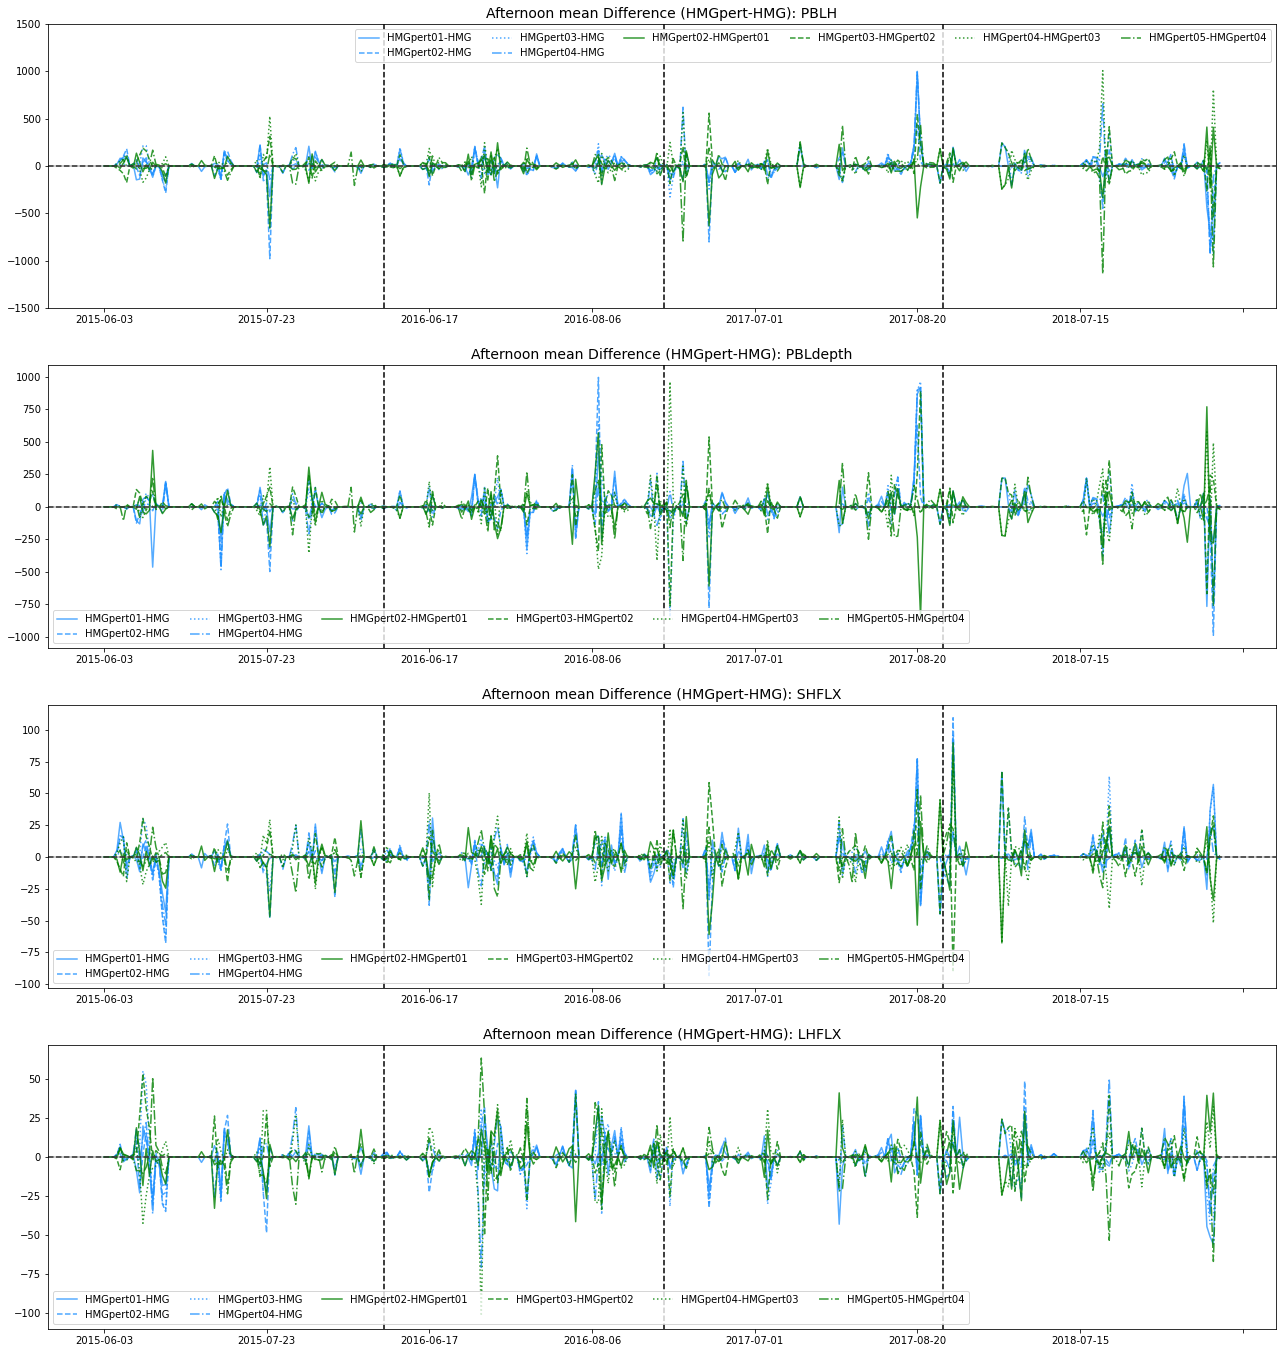

In [73]:
# Plot daily means...
plotVars = np.asarray(['PBLH','PBLdepth','SHFLX','LHFLX'])
nPlots = len(plotVars)

fig,axs = plt.subplots(nPlots,1, figsize=(22,6*nPlots))
axs     = axs.ravel()

for iPlot in range(nPlots):
    
    real_varHMG      = realSfcHMG_upsample[plotVars[iPlot]]
    real_varHTG      = realSfcHTG_upsample[plotVars[iPlot]]
    ens_var          = ensCases[plotVars[iPlot]]
    
    iHours_real         = np.where( (real_varHMG['time.hour']>=12) & (real_varHMG['time.hour']<=18) )[0]
    real_varHMG_selTime = real_varHMG.isel(time=iHours_real)
    real_varHTG_selTime = real_varHTG.isel(time=iHours_real)
    ens_var_selTime     = ens_var.isel(time=iHours_real)
    
    
    # For each date, get the mean value over the day
    real_varHMG_dayMean = real_varHMG_selTime.groupby('year_month_day').mean(dim='time')
    real_varHTG_dayMean = real_varHTG_selTime.groupby('year_month_day').mean(dim='time')
    ens_var_dayMean     = ens_var_selTime.groupby('year_month_day').mean(dim='time')
    
    diffHTG      = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==0)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diff_p1HTGp1 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==1)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==1)[0]).values
    diff_p2HTGp2 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==2)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==2)[0]).values
    diff_p3HTGp3 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==3)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==3)[0]).values
    diff_p4HTGp4 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==4)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==4)[0]).values
    diff_p5HTGp5 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==5)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==5)[0]).values


    diffHMGp1 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==1)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diffHMGp2 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==2)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diffHMGp3 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==3)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diffHMGp4 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==4)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diffHMGp2p1 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==2)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==1)[0]).values
    diffHMGp3p2 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==3)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==2)[0]).values
    diffHMGp4p3 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==4)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==3)[0]).values
    diffHMGp5p4 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==5)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==4)[0]).values

    diffEns   = ens_var_dayMean.isel(case=np.where(ens_var_dayMean.case.values=='HTGensMean')[0]).values-ens_var_dayMean.isel(case=np.where(ens_var_dayMean.case.values=='HMGensMean')[0]).values
    
    ## Plot lines 
    # axs[iPlot].plot(np.arange(len(np.squeeze(diffHTG))), np.squeeze(diffHTG),
    #                 color='red', alpha=0.75, label='HTG-HMG')
    # axs[iPlot].plot(np.arange(len(np.squeeze(diff_p1HTGp1))), np.squeeze(diff_p1HTGp1), 
    #                 color='red',linestyle='--', alpha=0.75, label='HTGpert01-HMGpert01')   # lightcoral
    # axs[iPlot].plot(np.arange(len(np.squeeze(diff_p2HTGp2))), np.squeeze(diff_p2HTGp2), 
    #                 color='red', linestyle=':', alpha=0.75, label='HTGpert02-HMGpert02') # orange
    # axs[iPlot].plot(np.arange(len(np.squeeze(diff_p3HTGp3))), np.squeeze(diff_p3HTGp3), 
    #                 color='red',linestyle='-.', alpha=0.75, label='HTGpert03-HMGpert03')   # lightcoral    
    # axs[iPlot].plot(np.arange(len(np.squeeze(diff_p4HTGp4))), np.squeeze(diff_p4HTGp4), 
    #                 color='lightcoral',linestyle='--', alpha=0.75, label='HTGpert04-HMGpert04')   # lightcoral     
    # axs[iPlot].plot(np.arange(len(np.squeeze(diff_p5HTGp5))), np.squeeze(diff_p5HTGp5), 
    #                 color='lightcoral',linestyle=':', alpha=0.75, label='HTGpert05-HMGpert05')   # lightcoral 
        
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp1))), np.squeeze(diffHMGp1), 
                    color='dodgerblue', alpha=0.75, label='HMGpert01-HMG')      # lightseagreen 
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp2))), np.squeeze(diffHMGp2), 
                    color='dodgerblue',linestyle='--', alpha=0.8, label='HMGpert02-HMG')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp3))), np.squeeze(diffHMGp3), 
                    color='dodgerblue',linestyle=':', alpha=0.8, label='HMGpert03-HMG')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp4))), np.squeeze(diffHMGp4), 
                    color='dodgerblue',linestyle='-.', alpha=0.8, label='HMGpert04-HMG')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp2p1))), np.squeeze(diffHMGp2p1), 
                    color='green',linestyle='-', alpha=0.8, label='HMGpert02-HMGpert01')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp3p2))), np.squeeze(diffHMGp3p2), 
                    color='green',linestyle='--', alpha=0.8, label='HMGpert03-HMGpert02')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp4p3))), np.squeeze(diffHMGp4p3), 
                    color='green',linestyle=':', alpha=0.8, label='HMGpert04-HMGpert03')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp5p4))), np.squeeze(diffHMGp5p4), 
                    color='green',linestyle='-.', alpha=0.8, label='HMGpert05-HMGpert04')
    
    # axs[iPlot].plot(np.arange(len(np.squeeze(diffEns))), np.squeeze(diffEns), 
    #                 'k', label='HTGens-HMGens')
        

    ## Add separating lines for ease of looking at these 
    axs[iPlot].axhline(0,color='k',linestyle='--')
    for iYr in range(len(yrStart)):
        axs[iPlot].axvline(yrStart[iYr], color='k',linestyle='--')


    # Plot markers for days that qualify as high/low changes
    # axs[iPlot].plot(np.arange(len(np.squeeze(diffEns)))[listHigh_real], np.squeeze(diffEns)[listHigh_real],'k^',markersize=9,alpha=0.4, label='HighDay')
    # axs[iPlot].plot(np.arange(len(np.squeeze(diffEns)))[listLow_real],  np.squeeze(diffEns)[listLow_real],'kv',markersize=9,alpha=0.4, label='LowDay')

    axs[iPlot].legend(ncol=6)
    axs[iPlot].axhline(0,color='grey',alpha=0.5)
    
    # Add labels
    # axs[iPlot].set_title('Afternoon mean Difference (HTG-HMG): '+plotVars[iPlot],fontsize=14)
    axs[iPlot].set_title('Afternoon mean Difference (HMGpert-HMG): '+plotVars[iPlot],fontsize=14)

    ## Set a few axis limits as needed
    # axs[iPlot].set_xlim([0,80])
    # axs[iPlot].set_xlim([60,88])
    # axs[iPlot].set_xlim([0,15])
    # axs[iPlot].set_ylim([-1500, 1500])
    
    # Control tick labels
    xTicks       = axs[iPlot].get_xticks()
    dates_xticks = strDates[xTicks.astype(int)[:-2]]
    axs[iPlot].set_xticklabels(dates_xticks)
    
    axs[0].set_ylim([-1500,1500])
    
    # axs[iPlot].grid()
    

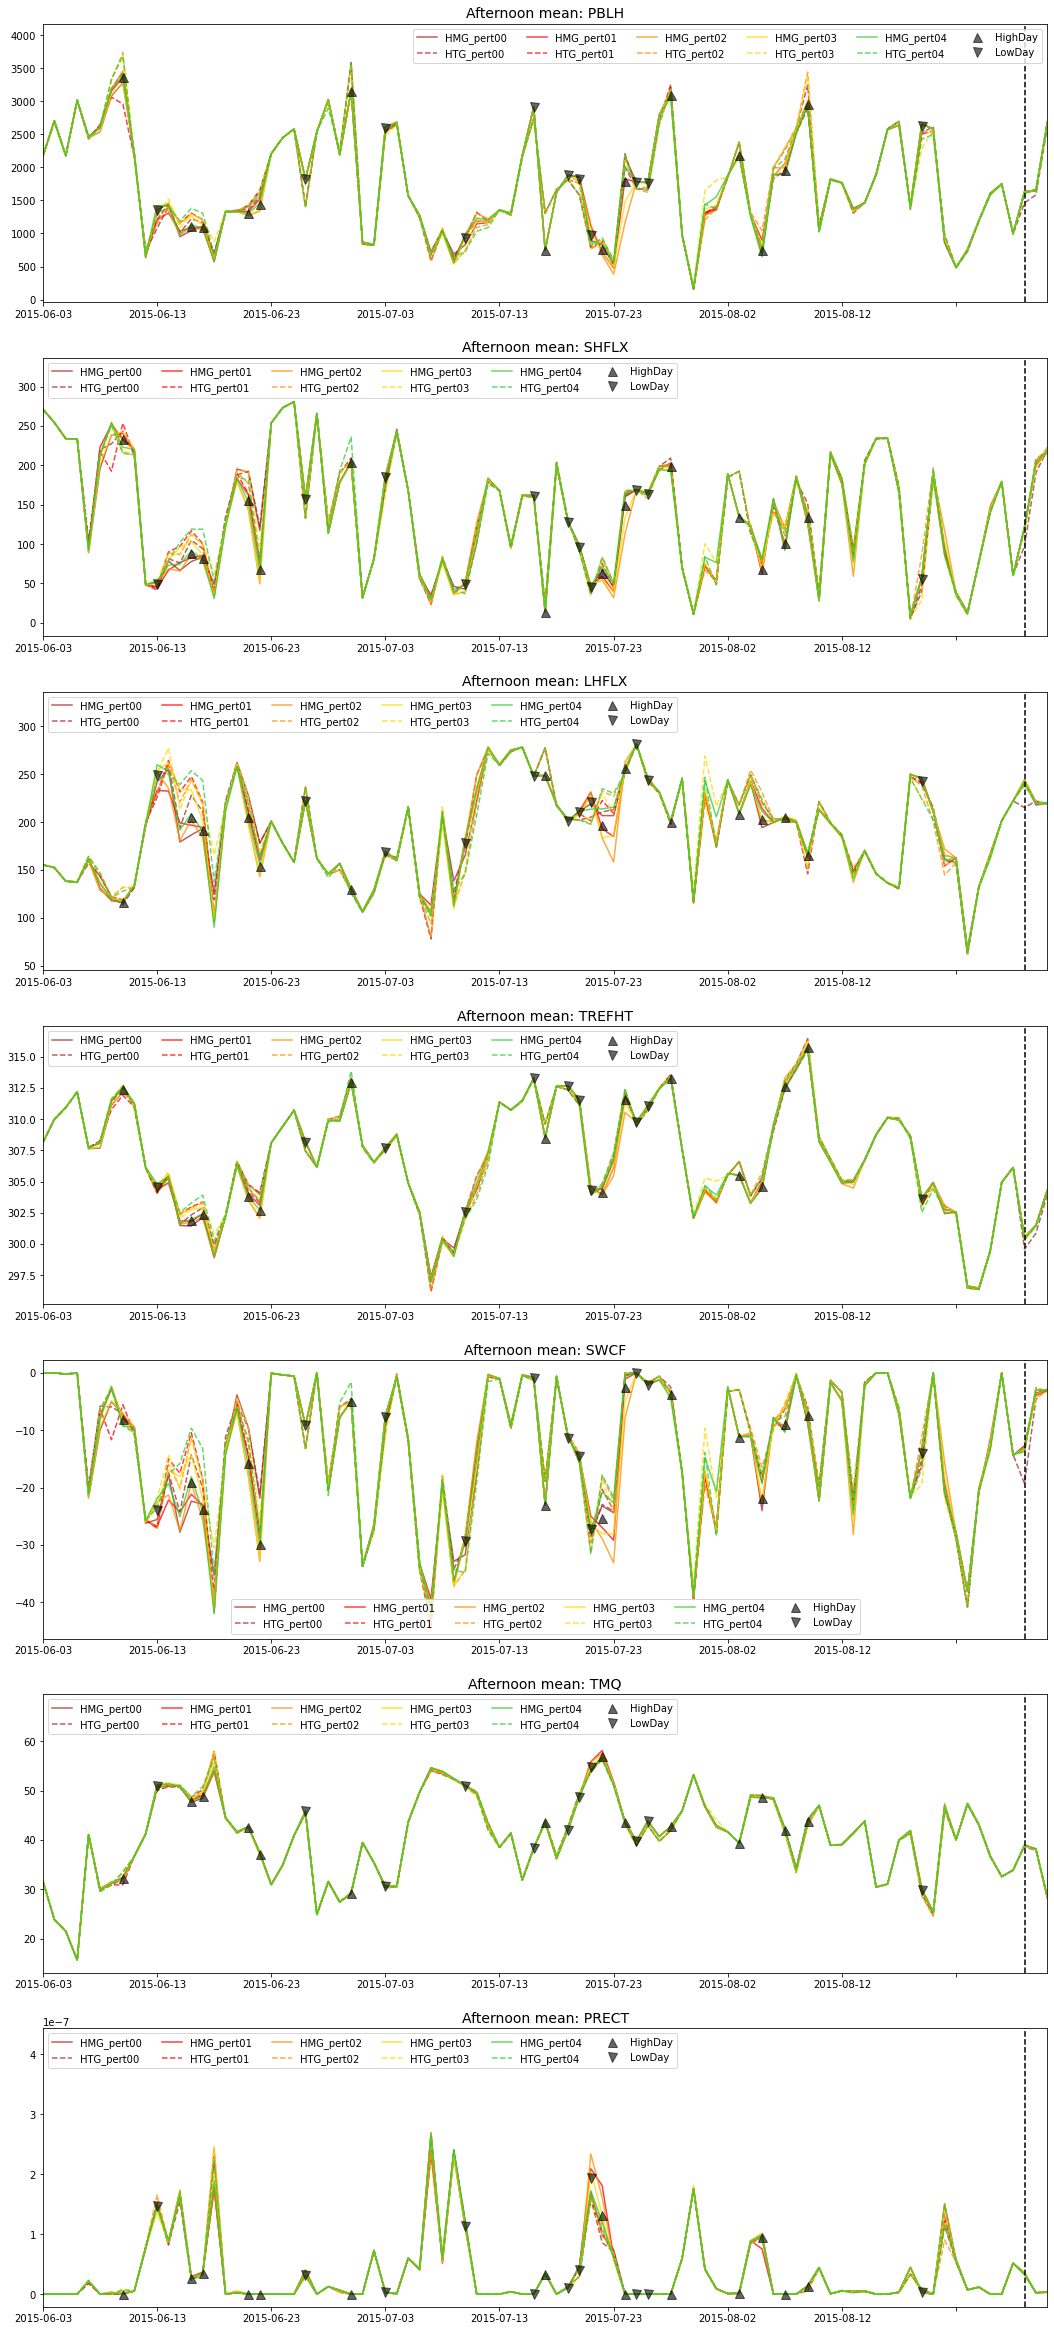

In [12]:
# Plot raw timeseries (based on afternoon mean values, so it's a bit more clear) 
plotVars = np.asarray(['PBLH','SHFLX','LHFLX','TREFHT','SWCF','TMQ','PRECT'])
nPlots = len(plotVars)

## Plot option for HMG/HTG lines 
pltTimeseries_HMG = True 
pltTimeseries_HTG = True 

fig,axs = plt.subplots(nPlots,1, figsize=(18,6*nPlots))
axs     = axs.ravel()

for iPlot in range(nPlots):
    
    real_varHMG      = realSfcHMG_upsample[plotVars[iPlot]]
    real_varHTG      = realSfcHTG_upsample[plotVars[iPlot]]
    ens_var          = ensCases[plotVars[iPlot]]
    
    iHours_real         = np.where( (real_varHMG['time.hour']>=12) & (real_varHMG['time.hour']<=18) )[0]
    real_varHMG_selTime = real_varHMG.isel(time=iHours_real)
    real_varHTG_selTime = real_varHTG.isel(time=iHours_real)
    ens_var_selTime     = ens_var.isel(time=iHours_real)
    
    
    # For each date, get the mean value over the day
    real_varHMG_dayMean = real_varHMG_selTime.groupby('year_month_day').mean(dim='time')
    real_varHTG_dayMean = real_varHTG_selTime.groupby('year_month_day').mean(dim='time')
    ens_var_dayMean     = ens_var_selTime.groupby('year_month_day').mean(dim='time')
    
    HMGensMean   = ens_var_dayMean.isel(case=np.where(ens_var_dayMean.case.values=='HMGensMean')[0]).values

    
    nDays = len(real_varHMG_dayMean.year_month_day.values)
        
    ## Plot lines 
    if pltTimeseries_HMG: 
        axs[iPlot].plot(np.arange(nDays), 
                        np.squeeze(real_varHMG_dayMean.isel(pertlim=0).values), 
                        color='brown', linestyle='-', alpha=0.75, label='HMG_pert00')
    if pltTimeseries_HTG:
        axs[iPlot].plot(np.arange(nDays), 
                        np.squeeze(real_varHTG_dayMean.isel(pertlim=0).values), 
                        color='brown', linestyle='--', alpha=0.75, label='HTG_pert00')
        
    if pltTimeseries_HMG: 
        axs[iPlot].plot(np.arange(nDays), 
                        np.squeeze(real_varHMG_dayMean.isel(pertlim=1).values), 
                        color='red', linestyle='-', alpha=0.75, label='HMG_pert01')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(np.arange(nDays), 
                        np.squeeze(real_varHTG_dayMean.isel(pertlim=1).values), 
                        color='red', linestyle='--', alpha=0.75, label='HTG_pert01')
        
    if pltTimeseries_HMG: 
        axs[iPlot].plot(np.arange(nDays), 
                        np.squeeze(real_varHMG_dayMean.isel(pertlim=2).values), 
                        color='darkorange', linestyle='-', alpha=0.75, label='HMG_pert02')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(np.arange(nDays), 
                        np.squeeze(real_varHTG_dayMean.isel(pertlim=2).values), 
                        color='darkorange', linestyle='--', alpha=0.75, label='HTG_pert02')
        
    if pltTimeseries_HMG: 
        axs[iPlot].plot(np.arange(nDays), 
                        np.squeeze(real_varHMG_dayMean.isel(pertlim=3).values), 
                        color='gold', linestyle='-', alpha=0.75, label='HMG_pert03')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(np.arange(nDays), 
                        np.squeeze(real_varHTG_dayMean.isel(pertlim=3).values), 
                        color='gold', linestyle='--', alpha=0.75, label='HTG_pert03')

    if pltTimeseries_HMG: 
        axs[iPlot].plot(np.arange(nDays), 
                        np.squeeze(real_varHMG_dayMean.isel(pertlim=4).values), 
                        color='limegreen', linestyle='-', alpha=0.75, label='HMG_pert04')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(np.arange(nDays), 
                        np.squeeze(real_varHTG_dayMean.isel(pertlim=4).values), 
                        color='limegreen', linestyle='--', alpha=0.75, label='HTG_pert04')

     
    ## Add separating lines for ease of looking at these 
    # axs[iPlot].axhline(0,color='k',linestyle='--')
    for iYr in range(len(yrStart)):
        axs[iPlot].axvline(yrStart[iYr], color='k',linestyle='--')
        
    # Plot markers for days that qualify as high/low changes
    axs[iPlot].plot(np.arange(len(np.squeeze(HMGensMean)))[listHigh_real], np.squeeze(HMGensMean)[listHigh_real],'k^',markersize=9,alpha=0.6, label='HighDay')
    axs[iPlot].plot(np.arange(len(np.squeeze(HMGensMean)))[listLow_real],  np.squeeze(HMGensMean)[listLow_real],'kv',markersize=9,alpha=0.6, label='LowDay')

        
    axs[iPlot].legend(ncol=6)
    
    # Add labels
    # axs[iPlot].set_title('Afternoon mean Difference (HTG-HMG): '+plotVars[iPlot],fontsize=14)
    axs[iPlot].set_title('Afternoon mean: '+plotVars[iPlot],fontsize=14)

    ## Set a few axis limits as needed
    axs[iPlot].set_xlim([0,88])
    # axs[iPlot].set_ylim([-1500, 1500])
    
    # Control tick labels
    xTicks       = axs[iPlot].get_xticks()
    dates_xticks = strDates[xTicks.astype(int)[:-2]]
    axs[iPlot].set_xticklabels(dates_xticks)
    
    
    

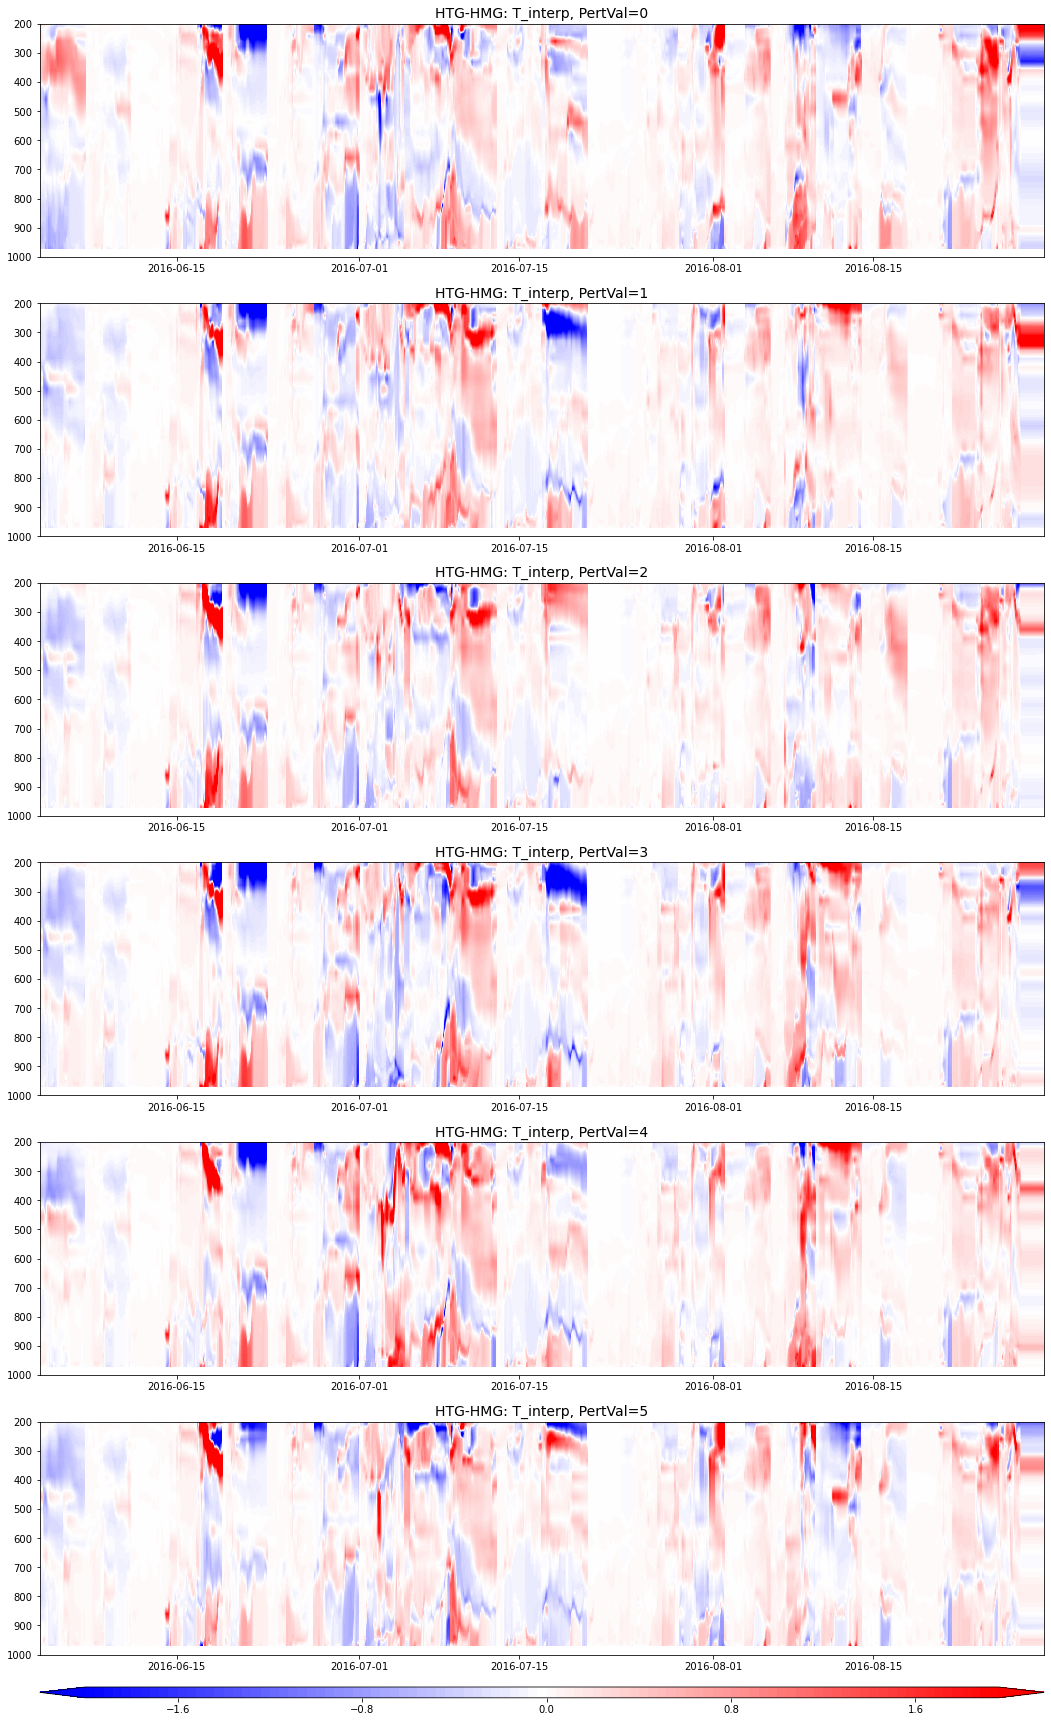

In [15]:
## Plot raw timeseries (time-hgt)

# Plot timeseries in the vertical

plotVars = 'T_interp'
levsDiff = np.arange(-2, 2, (4)/100.0)

nPlots   = len(realSfcHMG_upsample.pertlim.values)

fig,axs = plt.subplots(nPlots,1, figsize=(18,5*nPlots))
axs     = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

for iPlot in range(nPlots):
    
    real_varHMG  = realSfcHMG_upsample[plotVars].isel(pertlim=np.where(realSfcHMG_upsample.pertlim.values==iPlot)[0])
    real_varHTG  = realSfcHTG_upsample[plotVars].isel(pertlim=np.where(realSfcHTG_upsample.pertlim.values==iPlot)[0])
    diffHTG      = real_varHTG.values - real_varHMG.values

    timeArr = real_varHMG.time.values
    
    if np.shape(realSfcHMG_upsample[plotVars])[2]==64:
        levArr = realSfcHMG_upsample.lev.values 
    elif np.shape(realSfcHMG_upsample[plotVars])[2]==65:
        levArr = realSfcHMG_upsample.ilev.values 
    elif np.shape(realSfcHMG_upsample[plotVars])[2]==78:
        levArr = realSfcHMG_upsample.levInterp.values 
        
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -     
         
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - 
    ## Plot diff
    cplot = axs[iPlot].contourf(timeArr, levArr, np.squeeze(diffHTG).transpose(), 
                levsDiff, cmap='bwr', extend='both')
    
    # Add colorbar
    if iPlot==(nPlots-1): 
        ax_position = axs[iPlot].get_position()
        cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.02, ax_position.width, 0.005])
        cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()

        
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # Add labels

    axs[iPlot].set_title('HTG-HMG: '+plotVars+', PertVal='+str(iPlot),fontsize=14)

    axs[iPlot].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,30)])
    
    axs[iPlot].invert_yaxis()
    
    axs[iPlot].set_ylim([1000,200])
 
    



In [82]:
iPlot

1

   Date          HTG-HMGensMean 
(2015, 6, 3) -3.6582031
(2015, 6, 4) -12.152588
(2015, 6, 5) -1.9052734
(2015, 6, 6) 6.2373047
(2015, 6, 7) -24.840088
(2015, 6, 8) 35.735596
(2015, 6, 9) 80.54883
(2015, 6, 10) 127.35156
(2015, 6, 11) -56.431152
(2015, 6, 12) 82.14734
(2015, 6, 13) -151.97534
(2015, 6, 14) 32.266724
(2015, 6, 15) 59.256714
(2015, 6, 16) 133.77344
(2015, 6, 17) 96.68164
(2015, 6, 18) 80.29736
(2015, 6, 19) -0.9321289
(2015, 6, 20) 3.02771
(2015, 6, 21) 91.71533
(2015, 6, 22) 147.9541
(2015, 6, 23) -0.05126953
(2015, 6, 24) -0.06323242
(2015, 6, 25) -1.8276367
(2015, 6, 26) -412.97058
(2015, 6, 27) 1.845459
(2015, 6, 28) -61.74243
(2015, 6, 29) 37.467773
(2015, 6, 30) 343.8545
(2015, 7, 1) -28.150452
(2015, 7, 2) -12.740723
(2015, 7, 3) -70.671875
(2015, 7, 4) -30.67041
(2015, 7, 5) 8.559082
(2015, 7, 6) -34.06018
(2015, 7, 7) -6.447693
(2015, 7, 8) 23.853394
(2015, 7, 9) 35.669006
(2015, 7, 10) -97.62732
(2015, 7, 11) -43.49951
(2015, 7, 12) -37.6239
(2015, 7, 13) 0.994

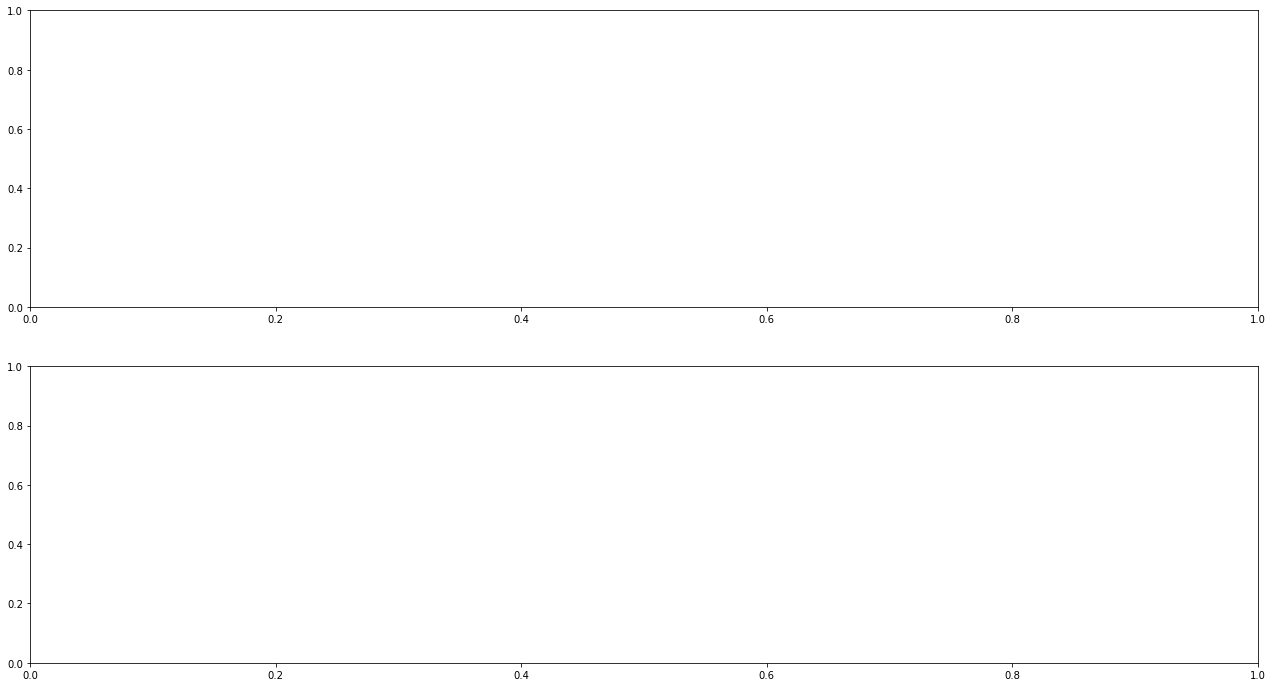

In [62]:
# Plot daily means...
plotVars = np.asarray(['PBLH','PBLdepth'])
nPlots = len(plotVars)

fig,axs = plt.subplots(nPlots,1, figsize=(22,6*nPlots))
axs     = axs.ravel()

for iPlot in range(nPlots):
    
    real_varHMG      = realSfcHMG_upsample[plotVars[iPlot]]
    real_varHTG      = realSfcHTG_upsample[plotVars[iPlot]]
    ens_var          = ensCases[plotVars[iPlot]]
    
    iHours_real         = np.where( (real_varHMG['time.hour']>=12) & (real_varHMG['time.hour']<=18) )[0]
    real_varHMG_selTime = real_varHMG.isel(time=iHours_real)
    real_varHTG_selTime = real_varHTG.isel(time=iHours_real)
    ens_var_selTime     = ens_var.isel(time=iHours_real)
    
    
    # For each date, get the mean value over the day
    real_varHMG_dayMean = real_varHMG_selTime.groupby('year_month_day').mean(dim='time')
    real_varHTG_dayMean = real_varHTG_selTime.groupby('year_month_day').mean(dim='time')
    ens_var_dayMean     = ens_var_selTime.groupby('year_month_day').mean(dim='time')
    
    nDays = len(real_varHMG_dayMean.year_month_day.values)
    
    diffHTG      = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==0)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diff_p1HTGp1 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==1)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==1)[0]).values
    diff_p2HTGp2 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==2)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==2)[0]).values
    diff_p3HTGp3 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==3)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==3)[0]).values
    diff_p4HTGp4 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==4)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==4)[0]).values
    diff_p5HTGp5 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==5)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==5)[0]).values


    diffHMGp1 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==1)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diffHMGp2 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==2)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diffHMGp3 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==3)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diffHMGp4 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==4)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diffHMGp2p1 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==2)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==1)[0]).values
    diffHMGp3p2 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==3)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==2)[0]).values
    diffHMGp4p3 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==4)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==3)[0]).values
    diffHMGp5p4 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==5)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==4)[0]).values

    diffEns   = ens_var_dayMean.isel(case=np.where(ens_var_dayMean.case.values=='HTGensMean')[0]).values-ens_var_dayMean.isel(case=np.where(ens_var_dayMean.case.values=='HMGensMean')[0]).values
    
    print('   Date          HTG-HMGensMean ')
    for iDay in range(nDays):
        print(real_varHMG_dayMean.year_month_day.values[iDay], np.squeeze(diffEns)[iDay])
    

**Plot some timeseries of land surface fields as well**

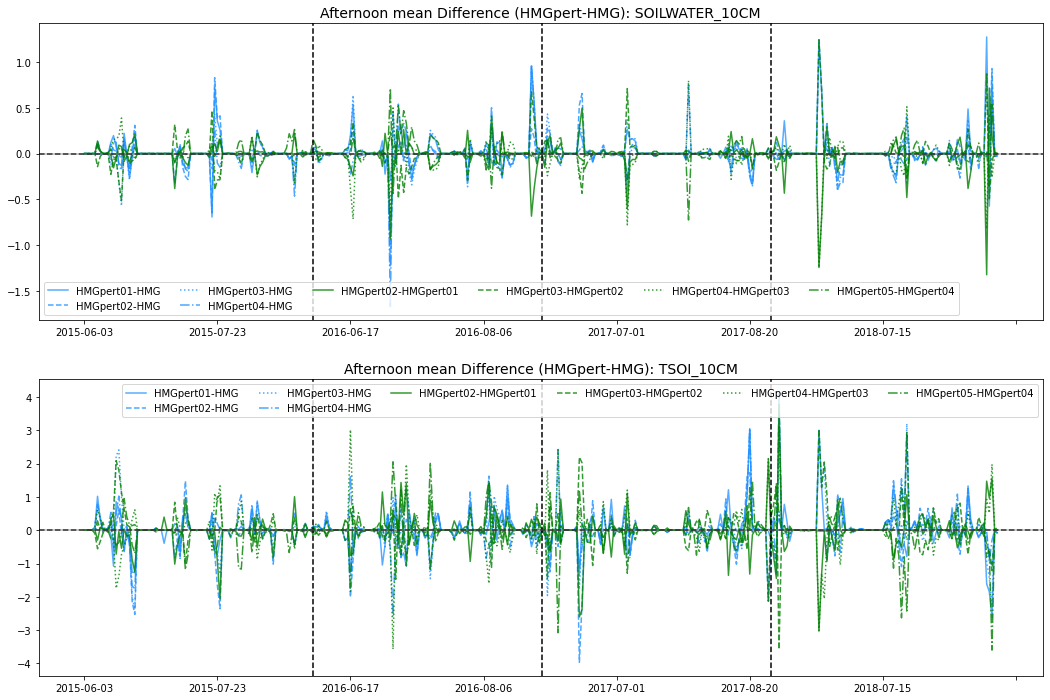

In [76]:
# Plot daily means...
plotVars = np.asarray(['SOILWATER_10CM','TSOI_10CM'])
nPlots = len(plotVars)

fig,axs = plt.subplots(nPlots,1, figsize=(18,6*nPlots))
axs     = axs.ravel()

for iPlot in range(nPlots):
    
    real_varHMG      = realSfcHMGclm_upsample[plotVars[iPlot]]
    real_varHTG      = realSfcHTGclm_upsample[plotVars[iPlot]]
    ens_var          = ensCasesCLM[plotVars[iPlot]]
    
    iHours_real         = np.where( (real_varHMG['time.hour']>=12) & (real_varHMG['time.hour']<=18) )[0]
    real_varHMG_selTime = real_varHMG.isel(time=iHours_real)
    real_varHTG_selTime = real_varHTG.isel(time=iHours_real)
    ens_var_selTime     = ens_var.isel(time=iHours_real)
    
    
    # For each date, get the mean value over the day
    real_varHMG_dayMean = real_varHMG_selTime.groupby('year_month_day').mean(dim='time')
    real_varHTG_dayMean = real_varHTG_selTime.groupby('year_month_day').mean(dim='time')
    ens_var_dayMean     = ens_var_selTime.groupby('year_month_day').mean(dim='time')
    
    # diffHTG      = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==0)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    # diff_p1HTGp1 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==1)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==1)[0]).values
    # diff_p2HTGp2 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==2)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==2)[0]).values
    # diff_p3HTGp3 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==3)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==3)[0]).values
    # diff_p4HTGp4 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==4)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==4)[0]).values
    # diff_p5HTGp5 = real_varHTG_dayMean.isel(pertlim=np.where(real_varHTG_dayMean.pertlim.values==5)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==5)[0]).values


    diffHMGp1 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==1)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diffHMGp2 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==2)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diffHMGp3 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==3)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diffHMGp4 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==4)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==0)[0]).values
    diffHMGp2p1 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==2)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==1)[0]).values
    diffHMGp3p2 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==3)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==2)[0]).values
    diffHMGp4p3 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==4)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==3)[0]).values
    diffHMGp5p4 = real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==5)[0]).values-real_varHMG_dayMean.isel(pertlim=np.where(real_varHMG_dayMean.pertlim.values==4)[0]).values

    
    diffEns   = ens_var_dayMean.isel(case=np.where(ens_var_dayMean.case.values=='HTGensMean')[0]).values-ens_var_dayMean.isel(case=np.where(ens_var_dayMean.case.values=='HMGensMean')[0]).values
    
    ## Plot lines 
    # axs[iPlot].plot(np.arange(len(np.squeeze(diffHTG))), np.squeeze(diffHTG), 
    #                 color='red', alpha=0.75, label='HTG-HMG')
    # axs[iPlot].plot(np.arange(len(np.squeeze(diff_p1HTGp1))), np.squeeze(diff_p1HTGp1), 
    #                 color='red',linestyle='--', alpha=0.75, label='HTGpert01-HMGpert01')   # lightcoral
    # axs[iPlot].plot(np.arange(len(np.squeeze(diff_p2HTGp2))), np.squeeze(diff_p2HTGp2), 
    #                 color='red', linestyle=':', alpha=0.75, label='HTGpert02-HMGpert02') # orange
    # axs[iPlot].plot(np.arange(len(np.squeeze(diff_p3HTGp3))), np.squeeze(diff_p3HTGp3), 
    #                 color='red',linestyle='-.', alpha=0.75, label='HTGpert03-HMGpert03')   # lightcoral    
    # axs[iPlot].plot(np.arange(len(np.squeeze(diff_p4HTGp4))), np.squeeze(diff_p4HTGp4), 
    #                 color='lightcoral',linestyle='--', alpha=0.75, label='HTGpert04-HMGpert04')   # lightcoral     
    # axs[iPlot].plot(np.arange(len(np.squeeze(diff_p5HTGp5))), np.squeeze(diff_p5HTGp5), 
    #                 color='lightcoral',linestyle=':', alpha=0.75, label='HTGpert05-HMGpert05')   # lightcoral  
        
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp1))), np.squeeze(diffHMGp1), 
                    color='dodgerblue', alpha=0.75, label='HMGpert01-HMG')      # lightseagreen 
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp2))), np.squeeze(diffHMGp2), 
                    color='dodgerblue',linestyle='--', alpha=0.8, label='HMGpert02-HMG')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp3))), np.squeeze(diffHMGp3), 
                    color='dodgerblue',linestyle=':', alpha=0.8, label='HMGpert03-HMG')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp4))), np.squeeze(diffHMGp4), 
                    color='dodgerblue',linestyle='-.', alpha=0.8, label='HMGpert04-HMG')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp2p1))), np.squeeze(diffHMGp2p1), 
                    color='green',linestyle='-', alpha=0.8, label='HMGpert02-HMGpert01')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp3p2))), np.squeeze(diffHMGp3p2), 
                    color='green',linestyle='--', alpha=0.8, label='HMGpert03-HMGpert02')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp4p3))), np.squeeze(diffHMGp4p3), 
                    color='green',linestyle=':', alpha=0.8, label='HMGpert04-HMGpert03')
    axs[iPlot].plot(np.arange(len(np.squeeze(diffHMGp5p4))), np.squeeze(diffHMGp5p4), 
                    color='green',linestyle='-.', alpha=0.8, label='HMGpert05-HMGpert04')

    
    # axs[iPlot].plot(np.arange(len(np.squeeze(diffEns))), np.squeeze(diffEns), 
    #                 'k', label='HTGens-HMGens')
        

    ## Add separating lines for ease of looking at these 
    axs[iPlot].axhline(0,color='k',linestyle='--')
    for iYr in range(len(yrStart)):
        axs[iPlot].axvline(yrStart[iYr], color='k',linestyle='--')


    # # Plot markers for days that qualify as high/low changes
    # axs[iPlot].plot(np.arange(len(np.squeeze(diffEns)))[listHigh_real], np.squeeze(diffEns)[listHigh_real],'k^',markersize=9,alpha=0.6, label='HighDay')
    # axs[iPlot].plot(np.arange(len(np.squeeze(diffEns)))[listLow_real],  np.squeeze(diffEns)[listLow_real],'kv',markersize=9,alpha=0.6, label='LowDay')

    axs[iPlot].legend(ncol=6)
    axs[iPlot].axhline(0,color='grey',alpha=0.5)
    
    # Add labels
    # axs[iPlot].set_title('Afternoon mean Difference (HTG-HMG): '+plotVars[iPlot],fontsize=14)
    axs[iPlot].set_title('Afternoon mean Difference (HMGpert-HMG): '+plotVars[iPlot],fontsize=14)

    ## Set a few axis limits as needed
    # axs[iPlot].set_xlim([0,88])
    # axs[iPlot].set_xlim([60,88])
    # axs[iPlot].set_xlim([0,15])
    # axs[iPlot].set_ylim([-1500, 1500])
    
    # Control tick labels
    xTicks       = axs[iPlot].get_xticks()
    dates_xticks = strDates[xTicks.astype(int)[:-2]]
    axs[iPlot].set_xticklabels(dates_xticks)
    
    
    

## Now get diurnal cycles of sensitive days 

In [41]:
# Get indices for all the other days too
allIndicies        = np.arange(0,len(strDates))
restOfIndices_real = list(set(allIndicies) - set(listHigh_real) - set(listLow_real))



In [42]:
## Get full arrays that match low/high percentiles

# HMG case
highPct_HMG  = getTimes_basedOnDates(realSfcHMG_upsample,     
                                         real_varHMG_dayMean.isel(year_month_day=listHigh_real))
lowPct_HMG   = getTimes_basedOnDates(realSfcHMG_upsample,     
                                         real_varHMG_dayMean.isel(year_month_day=listLow_real))

# HTG case
highPct_HTG  = getTimes_basedOnDates(realSfcHTG_upsample,     
                                         real_varHTG_dayMean.isel(year_month_day=listHigh_real))
lowPct_HTG   = getTimes_basedOnDates(realSfcHTG_upsample,     
                                         real_varHTG_dayMean.isel(year_month_day=listLow_real))

# Ens mean case
highPct_ensCases  = getTimes_basedOnDates(ensCases,     
                                         real_varHMG_dayMean.isel(year_month_day=listHigh_real))
lowPct_ensCases  = getTimes_basedOnDates(ensCases,     
                                         real_varHMG_dayMean.isel(year_month_day=listLow_real))

print('Done with high and low pct cases')


Done with high and low pct cases


In [43]:
## Get arrays with other % of days that don't fall into the category of the extremes 
restOfDays_HMG         = getTimes_basedOnDates(realSfcHMG_upsample,     
                                               real_varHMG_dayMean.isel(year_month_day=restOfIndices_real))

restOfDays_HTG         = getTimes_basedOnDates(realSfcHTG_upsample,     
                                               real_varHTG_dayMean.isel(year_month_day=restOfIndices_real))

print('Done getting datasets with rest of the days')



Done getting datasets with rest of the days


In [44]:
## Get hourly means in each category 
## - - - - - - - - - - - - - - - - - - 

hourlyMean_highPct_HMG   = highPct_HMG.groupby("time.hour").mean(dim="time")
hourlyMean_lowPct_HMG    = lowPct_HMG.groupby("time.hour").mean(dim="time")

hourlyMean_highPct_HTG   = highPct_HTG.groupby("time.hour").mean(dim="time")
hourlyMean_lowPct_HTG    = lowPct_HTG.groupby("time.hour").mean(dim="time")

hourlyMean_highPct_ensCases = highPct_ensCases.groupby("time.hour").mean(dim="time")
hourlyMean_lowPct_ensCases  = lowPct_ensCases.groupby("time.hour").mean(dim="time")
print('Computed hourly means for all surfaces + cases')


hourlyStd_highPct_HMG   = highPct_HMG.groupby("time.hour").std(dim="time")
hourlyStd_lowPct_HMG    = lowPct_HMG.groupby("time.hour").std(dim="time")

hourlyStd_highPct_HTG   = highPct_HTG.groupby("time.hour").std(dim="time")
hourlyStd_lowPct_HTG    = lowPct_HTG.groupby("time.hour").std(dim="time")

hourlyStd_highPct_ensCases  = highPct_ensCases.groupby("time.hour").std(dim="time")
hourlyStd_lowPct_ensCases   = lowPct_ensCases.groupby("time.hour").std(dim="time")
print('Computed hourly std for all surfaces + cases')


## Get rest of days too
hourlyMean_restOfDays_HMG      = restOfDays_HMG.groupby("time.hour").mean(dim="time")
hourlyMean_restOfDays_HTG      = restOfDays_HTG.groupby("time.hour").mean(dim="time")
print('Computed means for rest of days')

hourlyStd_restOfDays_HMG      = restOfDays_HMG.groupby("time.hour").std(dim="time")
hourlyStd_restOfDays_HTG      = restOfDays_HTG.groupby("time.hour").std(dim="time")
print('Computed std for rest of days')



Computed hourly means for all surfaces + cases
Computed hourly std for all surfaces + cases
Computed means for rest of days
Computed std for rest of days


In [45]:
hourlyMean_highPct_ensHMG       = highPct_HMG.groupby("time.hour").mean(dim=["time","pertlim"])
hourlyMean_highPct_ensHTG       = highPct_HTG.groupby("time.hour").mean(dim=["time","pertlim"])

hourlyMean_lowPct_ensHMG        = lowPct_HMG.groupby("time.hour").mean(dim=["time","pertlim"])
hourlyMean_lowPct_ensHTG        = lowPct_HTG.groupby("time.hour").mean(dim=["time","pertlim"])

hourlyMean_restOfDays_ensHMG    = restOfDays_HMG.groupby("time.hour").mean(dim=["time","pertlim"])
hourlyMean_restOfDays_ensHTG    = restOfDays_HTG.groupby("time.hour").mean(dim=["time","pertlim"])
print('Computed HMG and HTG specific means')


hourlyStd_highPct_ensHMG        = highPct_HMG.groupby("time.hour").std(dim=["time","pertlim"])
hourlyStd_highPct_ensHTG        = highPct_HTG.groupby("time.hour").std(dim=["time","pertlim"])

hourlyStd_lowPct_ensHMG         = lowPct_HMG.groupby("time.hour").std(dim=["time","pertlim"])
hourlyStd_lowPct_ensHTG         = lowPct_HTG.groupby("time.hour").std(dim=["time","pertlim"])

hourlyStd_restOfDays_ensHMG     = restOfDays_HMG.groupby("time.hour").std(dim=["time","pertlim"])
hourlyStd_restOfDays_ensHTG     = restOfDays_HTG.groupby("time.hour").std(dim=["time","pertlim"])
print('Computed HMG and HTG specific std')



Computed HMG and HTG specific means
Computed HMG and HTG specific std


In [46]:
# Get number of obs going into those hourly means (for error bars)
nTimes_highPct_HMG     = np.full([24], np.nan)
nTimes_lowPct_HMG      = np.full([24], np.nan)
nTimes_restOfDays_HMG  = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_highPct_HMG[iHr]    = len(np.where(highPct_HMG["time.hour"]==iHr)[0])
    nTimes_lowPct_HMG[iHr]     = len(np.where(lowPct_HMG["time.hour"]==iHr)[0])
    nTimes_restOfDays_HMG[iHr] = len(np.where(restOfDays_HMG["time.hour"]==iHr)[0])
    
hourlyMean_highPct_HMG['SampleCount']       = (('hour'), nTimes_highPct_HMG)
hourlyMean_lowPct_HMG['SampleCount']        = (('hour'), nTimes_lowPct_HMG)
hourlyMean_restOfDays_HMG['SampleCount']    = (('hour'), nTimes_restOfDays_HMG)

hourlyMean_highPct_HTG['SampleCount']       = (('hour'), nTimes_highPct_HMG)
hourlyMean_lowPct_HTG['SampleCount']        = (('hour'), nTimes_lowPct_HMG)
hourlyMean_restOfDays_HTG['SampleCount']    = (('hour'), nTimes_restOfDays_HMG)

hourlyMean_highPct_ensCases['SampleCount']       = (('hour'), nTimes_highPct_HMG)
hourlyMean_lowPct_ensCases['SampleCount']        = (('hour'), nTimes_lowPct_HMG)


In [47]:
nTimes_highPct_ensHMG    = np.full([24], np.nan)
nTimes_lowPct_ensHMG     = np.full([24], np.nan)
nTimes_restOfDays_ensHMG = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_highPct_ensHMG[iHr]    = len(np.where(highPct_HMG["time.hour"]==iHr)[0])*len(highPct_HMG['pertlim'].values)
    nTimes_lowPct_ensHMG[iHr]     = len(np.where(lowPct_HMG["time.hour"]==iHr)[0])*len(lowPct_HMG['pertlim'].values)
    nTimes_restOfDays_ensHMG[iHr] = len(np.where(restOfDays_HMG["time.hour"]==iHr)[0])*len(restOfDays_HMG['pertlim'].values)
    
hourlyMean_highPct_ensHMG['SampleCount'] = (('hour'), nTimes_highPct_ensHMG)
hourlyMean_highPct_ensHTG['SampleCount'] = (('hour'), nTimes_highPct_ensHMG)

hourlyMean_lowPct_ensHMG['SampleCount'] = (('hour'), nTimes_lowPct_ensHMG)
hourlyMean_lowPct_ensHTG['SampleCount'] = (('hour'), nTimes_lowPct_ensHMG)

hourlyMean_restOfDays_ensHMG['SampleCount'] = (('hour'), nTimes_restOfDays_ensHMG)
hourlyMean_restOfDays_ensHTG['SampleCount'] = (('hour'), nTimes_restOfDays_ensHMG)


In [48]:
def plotDiurnalCycle_sensDays_ens(varSelPlot, levSel, yMax, yMin):
    
    fig,axs = plt.subplots(1,3, figsize=(15,5))
    axs     = axs.ravel()
    
    # CIlevel = 1.960   ## 95% CI
    CIlevel = 1.645   ## 90% CI


    # Real surface 
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_ensHMG[varSelPlot].values[:,levSel]),
                    yerr =CIlevel*np.squeeze(hourlyStd_highPct_ensHMG[varSelPlot].values[:,levSel])/np.sqrt(hourlyMean_highPct_ensHMG['SampleCount'].values),
                    fmt='-',color='lightseagreen',capsize=3,label='HMG_ens')
    axs[0].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_highPct_ensHTG[varSelPlot].values[:,levSel]),
                    yerr =CIlevel*np.squeeze(hourlyStd_highPct_ensHTG[varSelPlot].values[:,levSel])/np.sqrt(hourlyMean_highPct_ensHTG['SampleCount'].values),
                    fmt='-',color='red',capsize=3,label='HTG_ens')
    axs[0].legend(fontsize=12)



    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_ensHMG[varSelPlot].values[:,levSel]),
                    yerr =CIlevel*np.squeeze(hourlyStd_lowPct_ensHMG[varSelPlot].values[:,levSel])/np.sqrt(hourlyMean_lowPct_ensHMG['SampleCount'].values),
                    fmt='-',color='lightseagreen',capsize=3)
    axs[1].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_lowPct_ensHTG[varSelPlot].values[:,levSel]),
                    yerr =CIlevel*np.squeeze(hourlyStd_lowPct_ensHTG[varSelPlot].values[:,levSel])/np.sqrt(hourlyMean_lowPct_ensHTG['SampleCount'].values),
                    fmt='-',color='red',capsize=3)


    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_ensHMG[varSelPlot].values[:,levSel]),
                    yerr =CIlevel*np.squeeze(hourlyStd_restOfDays_ensHMG[varSelPlot].values[:,levSel])/np.sqrt(hourlyMean_restOfDays_ensHMG['SampleCount'].values),
                    color='lightseagreen',capsize=3)
    axs[2].errorbar(np.arange(24), 
                    np.squeeze(hourlyMean_restOfDays_ensHTG[varSelPlot].values[:,levSel]),
                    yerr =CIlevel*np.squeeze(hourlyStd_restOfDays_ensHTG[varSelPlot].values[:,levSel])/np.sqrt(hourlyMean_restOfDays_ensHTG['SampleCount'].values),
                    color='red',capsize=3)


    # Set labels
    # axs[0].set_title(varSelPlot+'\n High percentiles of '+varSel+' (realSfc)', fontsize=14)
    axs[0].set_title(varSelPlot+'\n Large increases in '+varSel, fontsize=16)
    axs[1].set_title('Large decreases in '+varSel, fontsize=16)
    axs[2].set_title('Remaining days ', fontsize=16)
 
    if hasattr(realSfcHMG_upsample[varSelPlot], 'units'):
        axs[0].set_ylabel(realSfcHMG_upsample[varSelPlot].units, fontsize=12)
        
    axs[0].set_xlabel('Local Hour', fontsize=12)
    axs[1].set_xlabel('Local Hour', fontsize=12)
    axs[2].set_xlabel('Local Hour', fontsize=12)

    axs[0].tick_params(axis='both', labelsize= 12)
    axs[1].tick_params(axis='both', labelsize= 12)
    axs[2].tick_params(axis='both', labelsize= 12)

    # Set axis ranges if desired
    axs[0].set_ylim([yMin, yMax])
    axs[1].set_ylim([yMin, yMax])
    axs[2].set_ylim([yMin, yMax])
    
    return axs 

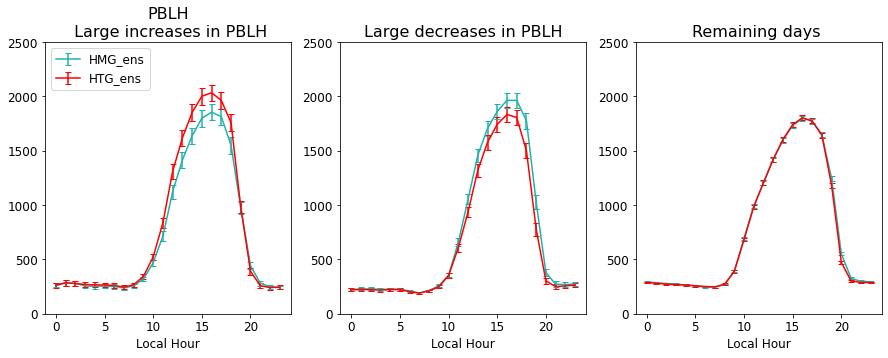

In [49]:
p1 = plotDiurnalCycle_sensDays_ens('PBLH', None, 2500, 0)

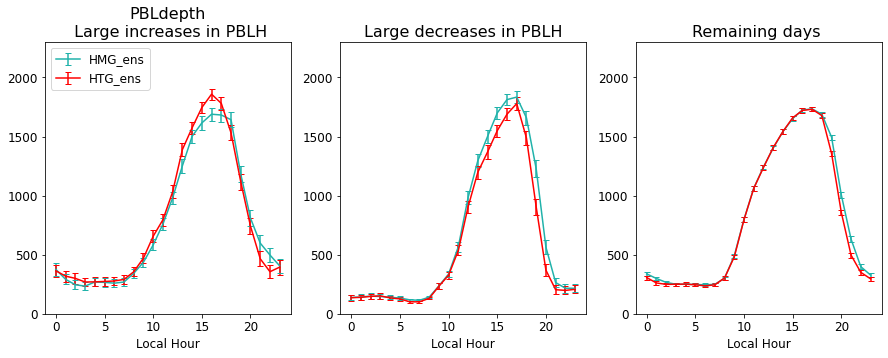

In [50]:
p2 = plotDiurnalCycle_sensDays_ens('PBLdepth', None, 2300, 0)

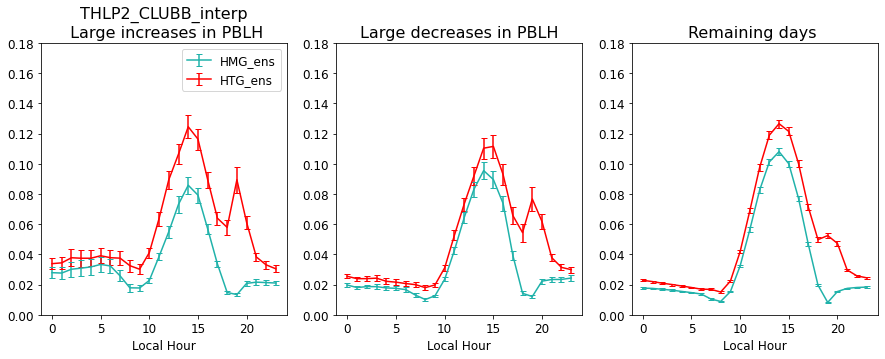

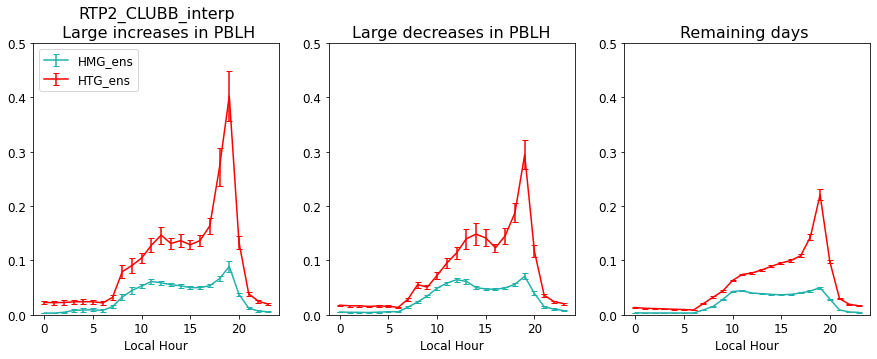

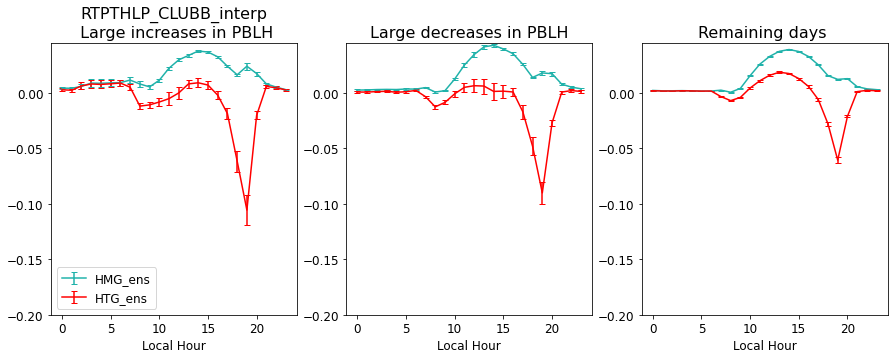

In [51]:
p1 = plotDiurnalCycle_sensDays_ens('THLP2_CLUBB_interp',   -1, 0.18,   0.00)   #level, yMax, yMin are last three inputs
p2 = plotDiurnalCycle_sensDays_ens('RTP2_CLUBB_interp',    -1, 0.5,    0.00)
p3 = plotDiurnalCycle_sensDays_ens('RTPTHLP_CLUBB_interp', -1, 0.045, -0.2)


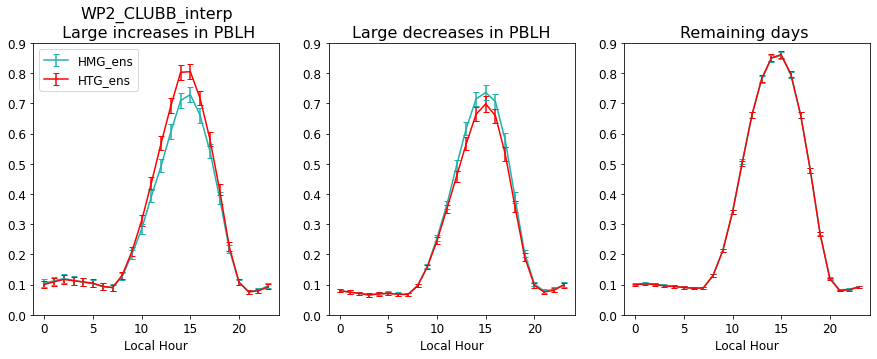

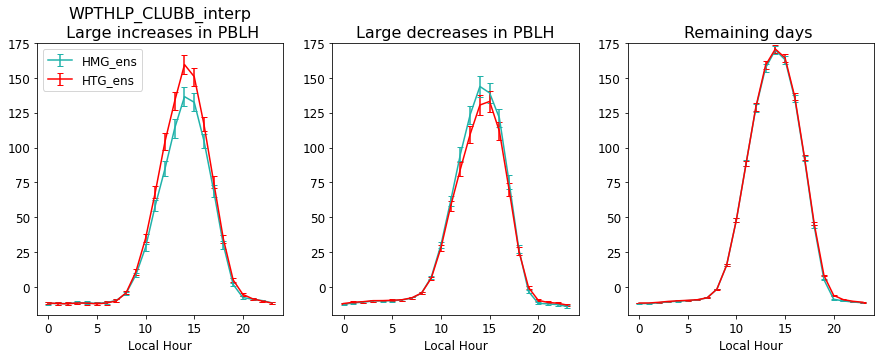

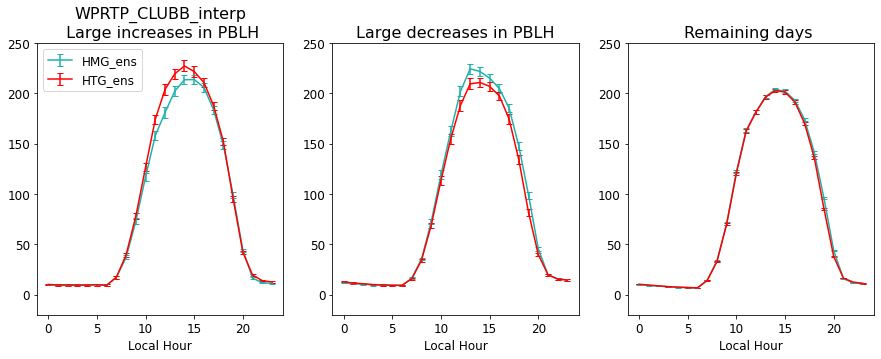

In [52]:
p1=plotDiurnalCycle_sensDays_ens('WP2_CLUBB_interp',    -1, 0.9, 0.0)   #level, yMax, yMin are last three inputs
p2=plotDiurnalCycle_sensDays_ens('WPTHLP_CLUBB_interp', -1, 175, -20)
p3=plotDiurnalCycle_sensDays_ens('WPRTP_CLUBB_interp', -1, 250, -20)


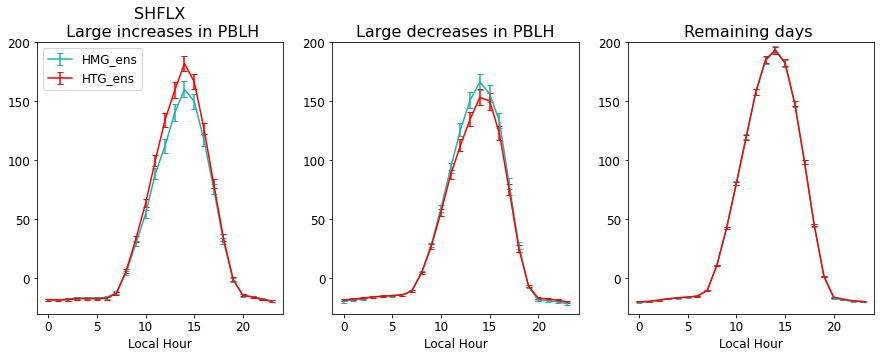

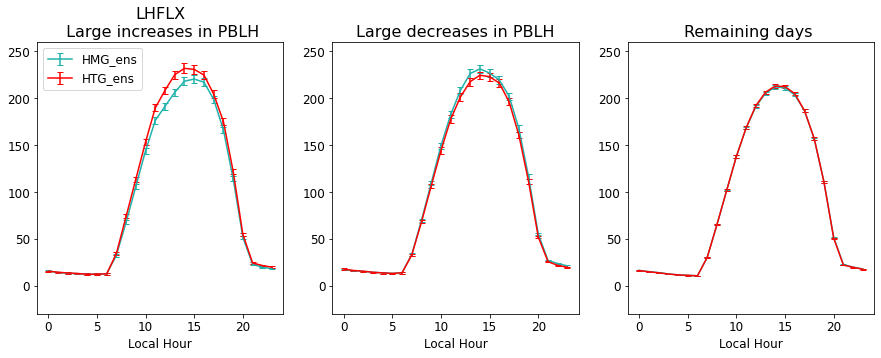

In [53]:
p1 = plotDiurnalCycle_sensDays_ens('SHFLX', None, 200, -30)
p2 = plotDiurnalCycle_sensDays_ens('LHFLX', None, 260, -30)


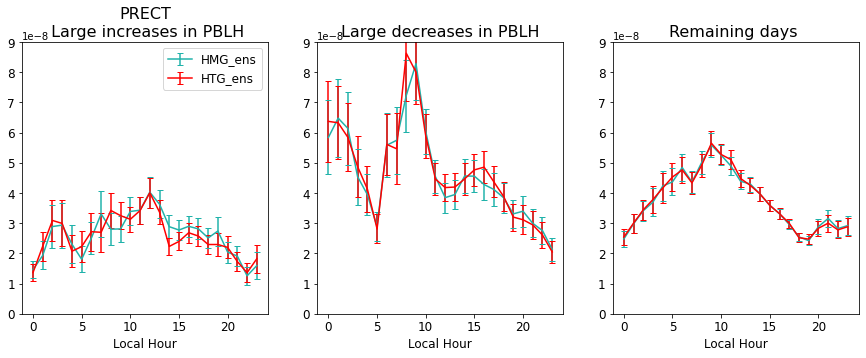

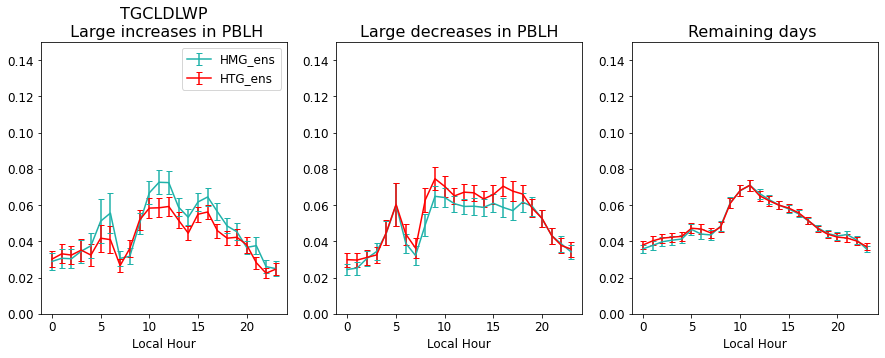

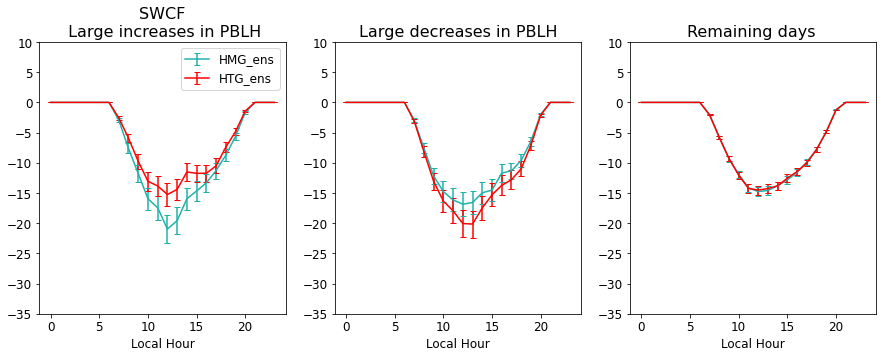

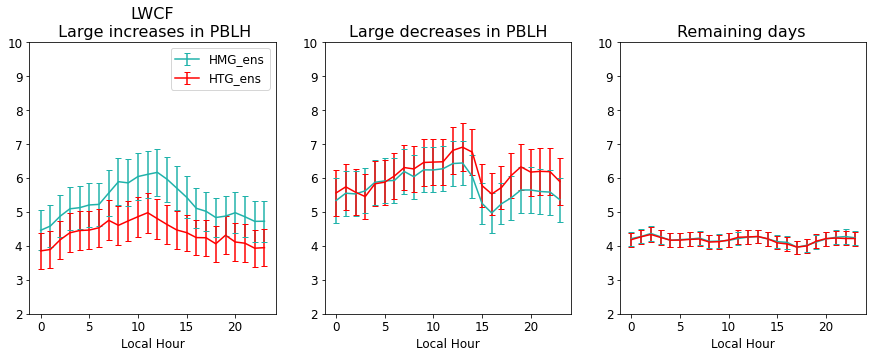

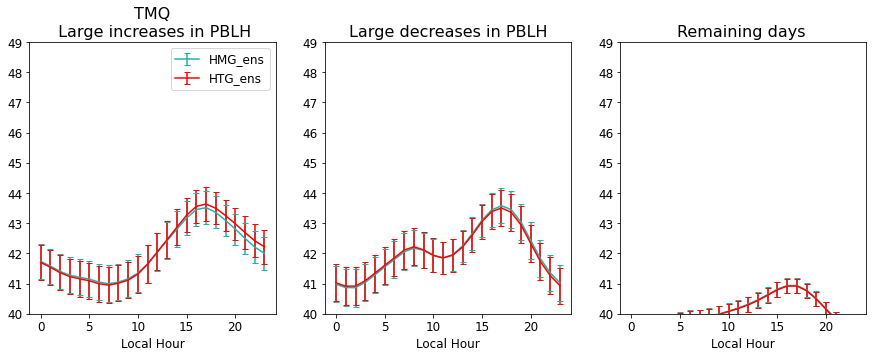

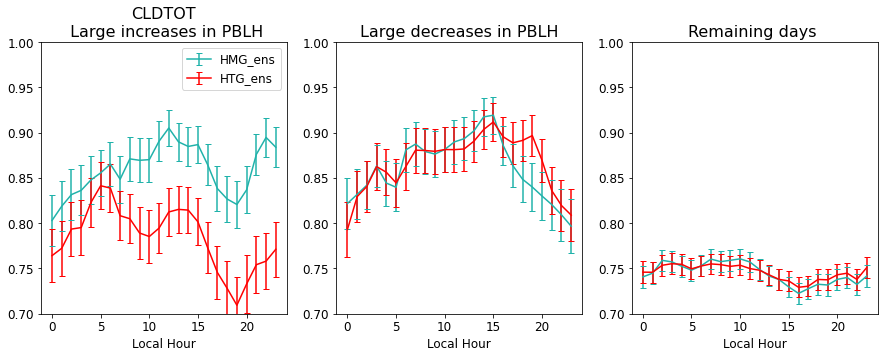

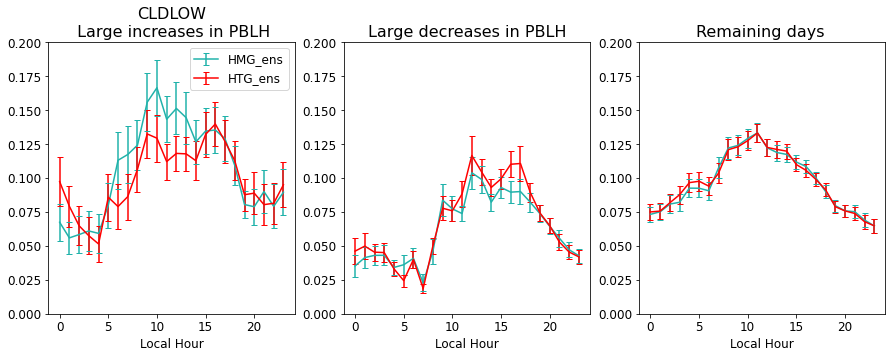

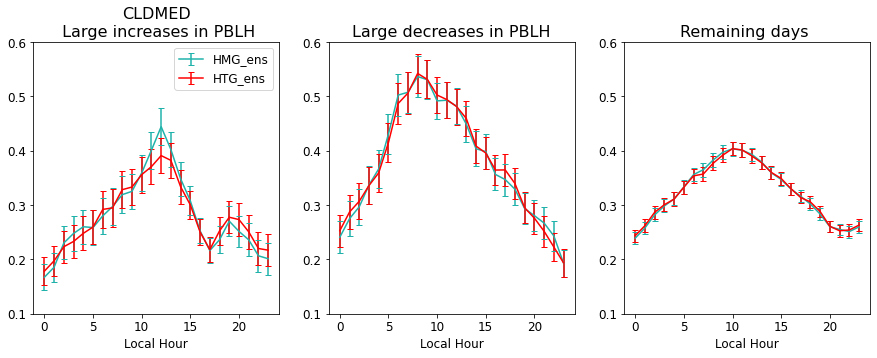

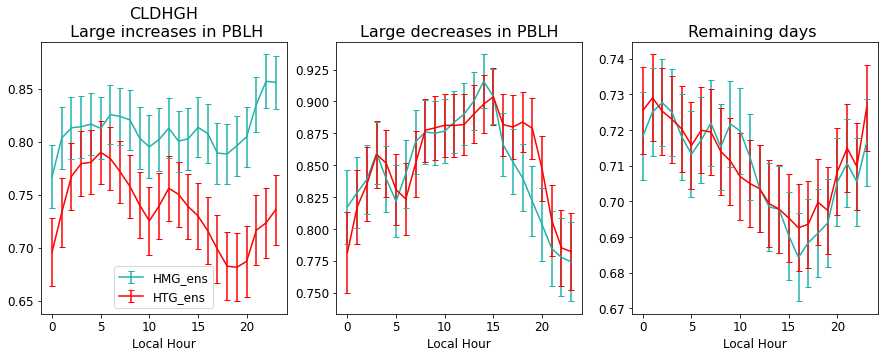

In [54]:
p0=plotDiurnalCycle_sensDays_ens('PRECT', None, 9e-8, 0)

p1=plotDiurnalCycle_sensDays_ens('TGCLDLWP', None, 0.15, 0)
p2=plotDiurnalCycle_sensDays_ens('SWCF', None, 10, -35)
p3=plotDiurnalCycle_sensDays_ens('LWCF', None, 10, 2)
p4=plotDiurnalCycle_sensDays_ens('TMQ',  None, 49, 40)

p5 = plotDiurnalCycle_sensDays_ens('CLDTOT', None, 1.0, 0.7)
p6 = plotDiurnalCycle_sensDays_ens('CLDLOW', None, 0.2, 0)
p7 = plotDiurnalCycle_sensDays_ens('CLDMED', None, 0.6, 0.1)
p8 = plotDiurnalCycle_sensDays_ens('CLDHGH', None, None, None)


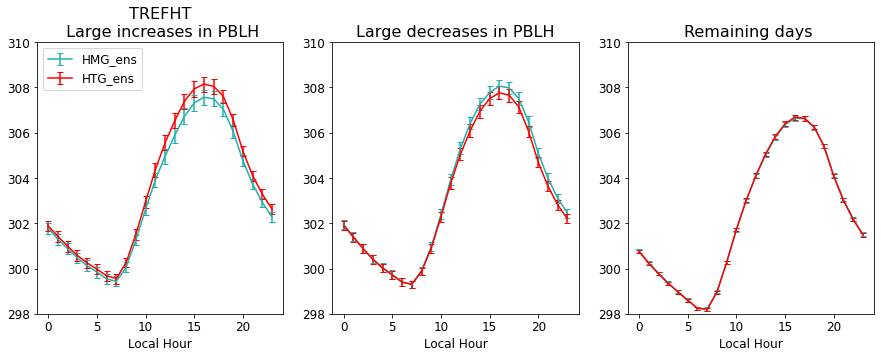

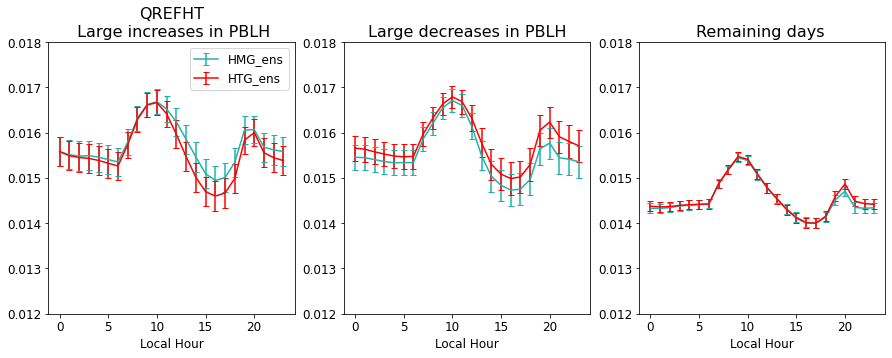

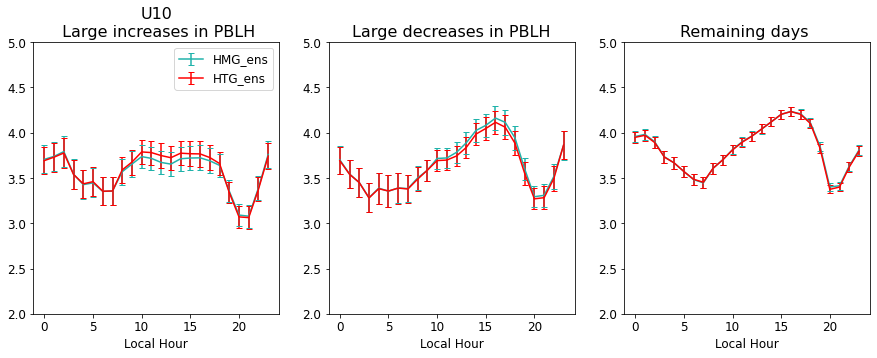

In [55]:
p1=plotDiurnalCycle_sensDays_ens('TREFHT', None, 310, 298)
p2=plotDiurnalCycle_sensDays_ens('QREFHT', None, 0.018, 0.012)
p3=plotDiurnalCycle_sensDays_ens('U10', None, 5, 2)


## Vertical Profiles

In [12]:
'''
Give this plotting routine the hourly mean DS' of high/low percentile filtering
'''
## Read in one file that has units on it (once you upsample, they disappear)

saveDir    = '/glade/work/mdfowler/CLASP/histData/processedData/'
realSfcHMG = pickle.load( open( saveDir+"realSfc_HMG_rtpthlponly_relaxTlongTau_freeSfcT.p" , "rb") )

def plotProfiles_meanOverHours(highPctDS_HMG, highPctDS_HTG,
                               lowPctDS_HMG, lowPctDS_HTG,
                               restOfDaysDS_HMG, restOfDaysDS_HTG,
                               varSelPlot,
                               startHr,endHr,
                               xMin, xMax, maxLev):
    
    caseNames = np.asarray(['HMG','HTG'])
    colorList = np.asarray(['lightseagreen','red'])

    ## Select which levels array to use
    if np.shape(highPctDS_HMG[varSelPlot].values)[2]==len(highPctDS_HMG.ilev.values):
        levSel = 'ilev'
    elif np.shape(highPctDS_HMG[varSelPlot].values)[2]==len(highPctDS_HMG.lev.values):
        levSel = 'lev'
    elif np.shape(highPctDS_HMG[varSelPlot].values)[2]==len(highPctDS_HMG.levInterp.values):
        levSel = 'levInterp'
        
                            
    ## First, get means (& std) over the selected hours and ens cases
    iTimeSel_high = np.where((highPctDS_HMG["time.hour"].values>=startHr) & 
                             (highPctDS_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_low  = np.where((lowPctDS_HMG["time.hour"].values>=startHr) & 
                             (lowPctDS_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_rest = np.where((restOfDaysDS_HMG["time.hour"].values>=startHr) & 
                             (restOfDaysDS_HMG["time.hour"].values<=endHr))[0]
    
    
    hourlyMean_highTimeSel_HMG   = highPctDS_HMG.isel(time=iTimeSel_high).mean(dim=["time","pertlim"])
    hourlyMean_lowTimeSel_HMG    = lowPctDS_HMG.isel(time=iTimeSel_low).mean(dim=["time","pertlim"])
    hourlyMean_restTimeSel_HMG   = restOfDaysDS_HMG.isel(time=iTimeSel_rest).mean(dim=["time","pertlim"])
    
    hourlyStd_highTimeSel_HMG   = highPctDS_HMG.isel(time=iTimeSel_high).std(dim=["time","pertlim"])
    hourlyStd_lowTimeSel_HMG    = lowPctDS_HMG.isel(time=iTimeSel_low).std(dim=["time","pertlim"])
    hourlyStd_restTimeSel_HMG   = restOfDaysDS_HMG.isel(time=iTimeSel_rest).std(dim=["time","pertlim"])
    
    
    hourlyMean_highTimeSel_HTG   = highPctDS_HTG.isel(time=iTimeSel_high).mean(dim=["time","pertlim"])
    hourlyMean_lowTimeSel_HTG    = lowPctDS_HTG.isel(time=iTimeSel_low).mean(dim=["time","pertlim"])
    hourlyMean_restTimeSel_HTG   = restOfDaysDS_HTG.isel(time=iTimeSel_rest).mean(dim=["time","pertlim"])
    
    hourlyStd_highTimeSel_HTG   = highPctDS_HTG.isel(time=iTimeSel_high).std(dim=["time","pertlim"])
    hourlyStd_lowTimeSel_HTG    = lowPctDS_HTG.isel(time=iTimeSel_low).std(dim=["time","pertlim"])
    hourlyStd_restTimeSel_HTG   = restOfDaysDS_HTG.isel(time=iTimeSel_rest).std(dim=["time","pertlim"])
    
    
    # Select the requested variable
    HMGvar_high   = np.squeeze(hourlyMean_highTimeSel_HMG[varSelPlot].values)
    HMGvar_low    = np.squeeze(hourlyMean_lowTimeSel_HMG[varSelPlot].values)
    HMGvar_rest   = np.squeeze(hourlyMean_restTimeSel_HMG[varSelPlot].values)

    HTGvar_high   = np.squeeze(hourlyMean_highTimeSel_HTG[varSelPlot].values)
    HTGvar_low    = np.squeeze(hourlyMean_lowTimeSel_HTG[varSelPlot].values)
    HTGvar_rest   = np.squeeze(hourlyMean_restTimeSel_HTG[varSelPlot].values)


    # Also get the std of that variable... 
    HMGvarStd_high   = np.squeeze(hourlyStd_highTimeSel_HMG[varSelPlot].values)
    HMGvarStd_low    = np.squeeze(hourlyStd_lowTimeSel_HMG[varSelPlot].values)
    HMGvarStd_rest   = np.squeeze(hourlyStd_restTimeSel_HMG[varSelPlot].values)

    HTGvarStd_high   = np.squeeze(hourlyStd_highTimeSel_HTG[varSelPlot].values)
    HTGvarStd_low    = np.squeeze(hourlyStd_lowTimeSel_HTG[varSelPlot].values)
    HTGvarStd_rest   = np.squeeze(hourlyStd_restTimeSel_HTG[varSelPlot].values)
    
 
    ## Set up figure
    fig,axs = plt.subplots(1,3, figsize=(15,5))
    axs     = axs.ravel()
    fig.subplots_adjust(hspace=0.2)

    atmLevs = highPctDS_HMG[levSel].values

    ## Define confidence level to rely on
    # CIlevel = 1.960   ## 95% CI
    CIlevel = 1.645   ## 90% CI

    ## - - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Plot profiles
    axs[0].errorbar(HMGvar_high,   atmLevs,
                    xerr=CIlevel*(HMGvarStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color=colorList[0], label=caseNames[0])
    axs[0].errorbar(HTGvar_high,   atmLevs, 
                    xerr=CIlevel*(HTGvarStd_high/np.sqrt(len(iTimeSel_high))),
                    capsize=3, color=colorList[1], label=caseNames[1])
    axs[0].legend(fontsize=12)

    
    axs[1].errorbar(HMGvar_low,   atmLevs, 
                    xerr=CIlevel*(HMGvarStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color=colorList[0], label=caseNames[0])
    axs[1].errorbar(HTGvar_low,   atmLevs,
                    xerr=CIlevel*(HTGvarStd_low/np.sqrt(len(iTimeSel_low))),
                    capsize=3, color=colorList[1], label=caseNames[1])

                     
                     
    axs[2].errorbar(HMGvar_rest,   atmLevs,
                    xerr=CIlevel*(HMGvarStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color=colorList[0], label=caseNames[0])
    axs[2].errorbar(HTGvar_rest,   atmLevs, 
                    xerr=CIlevel*(HTGvarStd_rest/np.sqrt(len(iTimeSel_rest))),
                    capsize=3, color=colorList[1], label=caseNames[1])

    

    ## - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Other plot options
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()

    axs[0].set_ylim([980, maxLev])
    axs[1].set_ylim([980, maxLev])
    axs[2].set_ylim([980, maxLev])
    
    axs[0].set_xlim([xMin, xMax])
    axs[1].set_xlim([xMin, xMax])
    axs[2].set_xlim([xMin, xMax])
    
    axs[1].axes.yaxis.set_ticklabels([])
    axs[2].axes.yaxis.set_ticklabels([])   

    axs[0].set_title(varSelPlot+'\n Large increases in '+varSel, fontsize=16)       
    axs[1].set_title('Large decreases in '+varSel, fontsize=16)
    axs[2].set_title('Remaining days', fontsize=16)

    axs[0].set_xlabel(realSfcHMG[varSelPlot].units, fontsize=12)
    axs[1].set_xlabel(realSfcHMG[varSelPlot].units, fontsize=12)
    axs[2].set_xlabel(realSfcHMG[varSelPlot].units, fontsize=12)
    
    if varSelPlot.endswith('_interp'):
        axs[0].set_ylabel('hPa', fontsize=12)
    else:
        axs[0].set_ylabel('hPa (model hybrid coord)', fontsize=12)

    axs[0].tick_params(axis='both', labelsize= 12)
    axs[1].tick_params(axis='both', labelsize= 12)
    axs[2].tick_params(axis='both', labelsize= 12)

    return

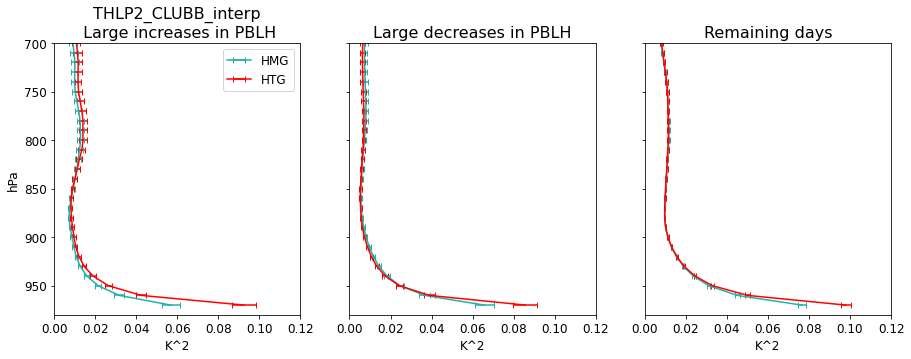

In [61]:
plotProfiles_meanOverHours(highPct_HMG, highPct_HTG, 
                           lowPct_HMG,  lowPct_HTG,
                           restOfDays_HMG, restOfDays_HTG,
                          'THLP2_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           0,       # Min x value
                           0.12,     # Max x value
                           700)     # Max level 


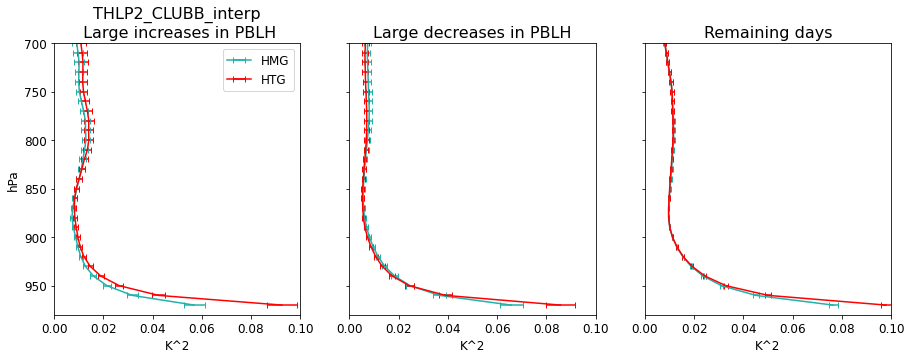

In [65]:
plotProfiles_meanOverHours(highPct_HMG, highPct_HTG, 
                           lowPct_HMG,  lowPct_HTG,
                           restOfDays_HMG, restOfDays_HTG,
                          'THLP2_CLUBB_interp',
                           12, 18,  # Start hr, end hr
                           0,       # Min x value
                           0.1,    # Max x value
                           700)     # Max level 

## Look at individual consistent days

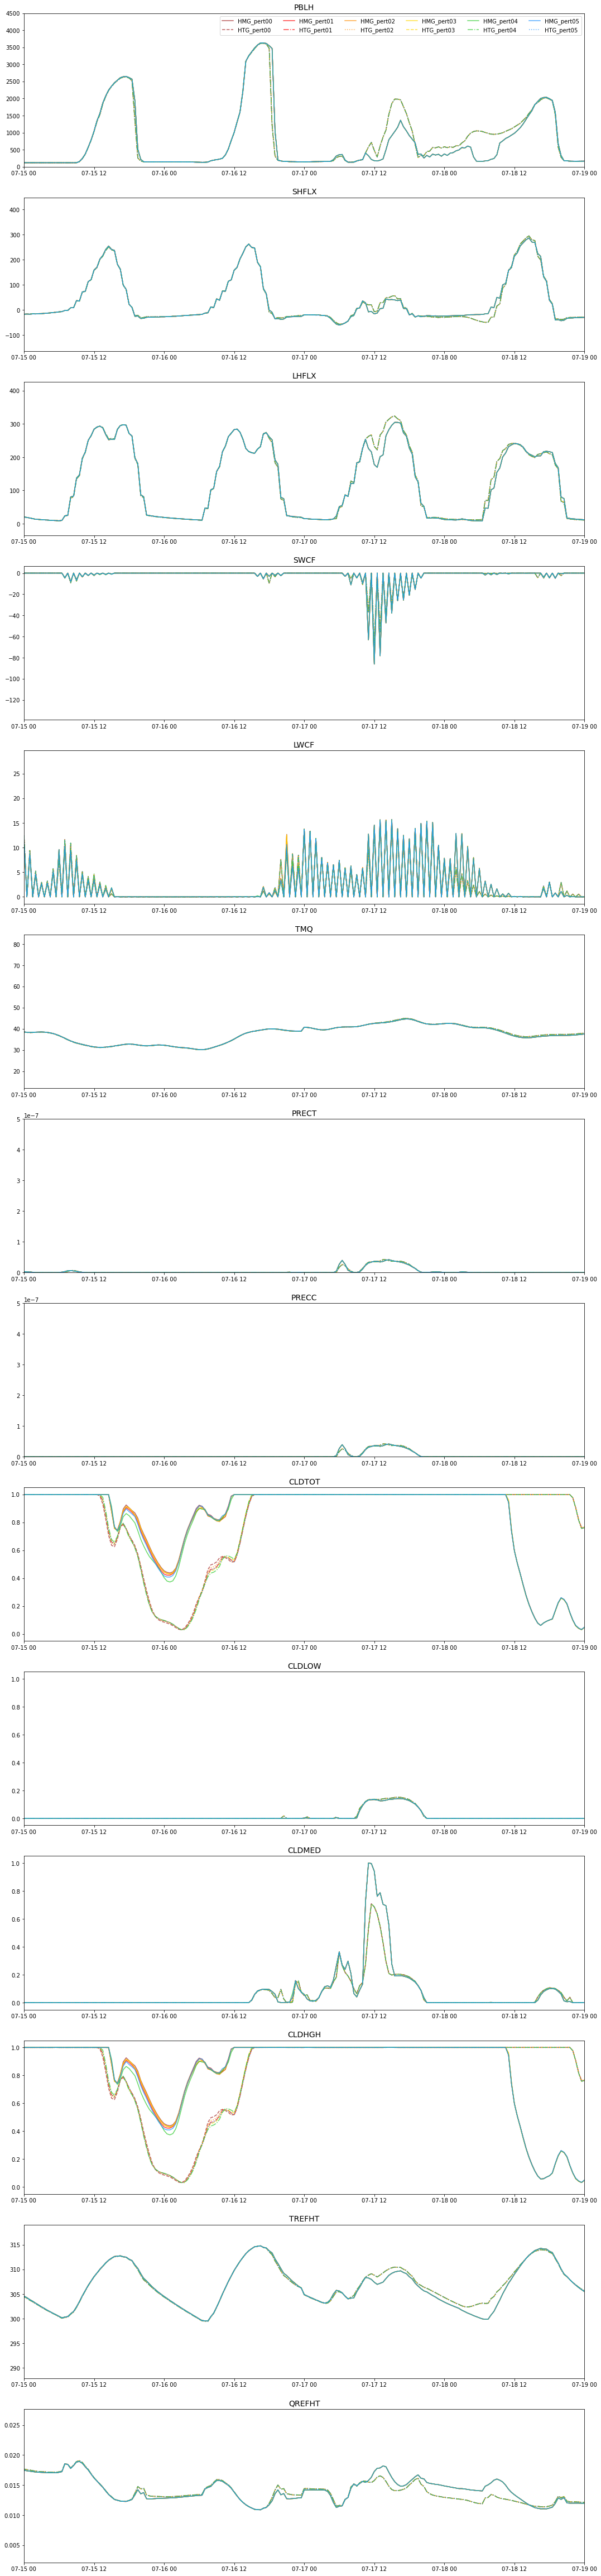

In [47]:
# Plot raw timeseries (based on afternoon mean values, so it's a bit more clear) 
plotVars = np.asarray(['PBLH','SHFLX','LHFLX','SWCF','LWCF','TMQ','PRECT','PRECC','CLDTOT','CLDLOW','CLDMED','CLDHGH','TREFHT','QREFHT'])
nPlots = len(plotVars)

## Plot option for HMG/HTG lines 
pltTimeseries_HMG = True 
pltTimeseries_HTG = True 

fig,axs = plt.subplots(nPlots,1, figsize=(18,6*nPlots))
axs     = axs.ravel()

for iPlot in range(nPlots):
    
    real_varHMG      = realSfcHMG_upsample[plotVars[iPlot]]
    real_varHTG      = realSfcHTG_upsample[plotVars[iPlot]]
    ens_var          = ensCases[plotVars[iPlot]]

    timeArr = real_varHMG.time.values
    
    ## Plot lines 
    if pltTimeseries_HMG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHMG.isel(pertlim=np.where(real_varHMG.pertlim.values==0)[0]).values), 
                        color='brown', linestyle='-', alpha=0.75, label='HMG_pert00')
    if pltTimeseries_HTG:
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHTG.isel(pertlim=np.where(real_varHTG.pertlim.values==0)[0]).values), 
                        color='brown', linestyle='--', alpha=0.75, label='HTG_pert00')
        
    if pltTimeseries_HMG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHMG.isel(pertlim=np.where(real_varHMG.pertlim.values==1)[0]).values), 
                        color='red', linestyle='-', alpha=0.75, label='HMG_pert01')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHTG.isel(pertlim=np.where(real_varHTG.pertlim.values==1)[0]).values), 
                        color='red', linestyle='-.', alpha=0.75, label='HTG_pert01')
        
    if pltTimeseries_HMG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHMG.isel(pertlim=2).values), 
                        color='darkorange', linestyle='-', alpha=0.75, label='HMG_pert02')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHTG.isel(pertlim=2).values), 
                        color='darkorange', linestyle=':', alpha=0.75, label='HTG_pert02')
        
    if pltTimeseries_HMG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHMG.isel(pertlim=3).values), 
                        color='gold', linestyle='-', alpha=0.75, label='HMG_pert03')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHTG.isel(pertlim=3).values), 
                        color='gold', linestyle='--', alpha=0.75, label='HTG_pert03')

    if pltTimeseries_HMG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHMG.isel(pertlim=4).values), 
                        color='limegreen', linestyle='-', alpha=0.75, label='HMG_pert04')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHTG.isel(pertlim=4).values), 
                        color='limegreen', linestyle='-.', alpha=0.75, label='HTG_pert04')
        
    if pltTimeseries_HMG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHMG.isel(pertlim=5).values), 
                        color='dodgerblue', linestyle='-', alpha=0.75, label='HMG_pert05')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHTG.isel(pertlim=5).values), 
                        color='dodgerblue', linestyle=':', alpha=0.75, label='HTG_pert05')

     
    ## Add separating lines for ease of looking at these 
    # axs[iPlot].axhline(0,color='k',linestyle='--')
    for iYr in range(len(yrStart)):
        axs[iPlot].axvline(yrStart[iYr], color='k',linestyle='--')
        
    # # Plot markers for days that qualify as high/low changes
    # axs[iPlot].plot(strDates[listHigh_real], np.squeeze(HMGensMean)[listHigh_real],'k^',markersize=9,alpha=0.6, label='HighDay')
    # axs[iPlot].plot(strDates[listLow_real],  np.squeeze(HMGensMean)[listLow_real],'kv',markersize=9,alpha=0.6, label='LowDay')

        
    
    
    # Add labels
    axs[iPlot].set_title(plotVars[iPlot],fontsize=14)

    ## Set a few axis limits as needed
    # axs[iPlot].set_xlim([0,88])
    # axs[iPlot].set_ylim([-1500, 1500])
    
    # # Control tick labels
    # xTicks       = axs[iPlot].get_xticks()
    # dates_xticks = strDates[xTicks.astype(int)[:-2]]
    # axs[iPlot].set_xticklabels(dates_xticks)
    
    axs[iPlot].set_xlim([datetime.date(2015,7,15), datetime.date(2015,7,19)])
    
    if ((plotVars[iPlot]=='PRECT') | (plotVars[iPlot]=='PRECC') | (plotVars[iPlot]=='PRECZ') ):
        axs[iPlot].set_ylim([0, 0.5e-6])

axs[0].set_ylim([0,4500]) 
axs[0].legend(ncol=6)
    

(18.0, 25.0)

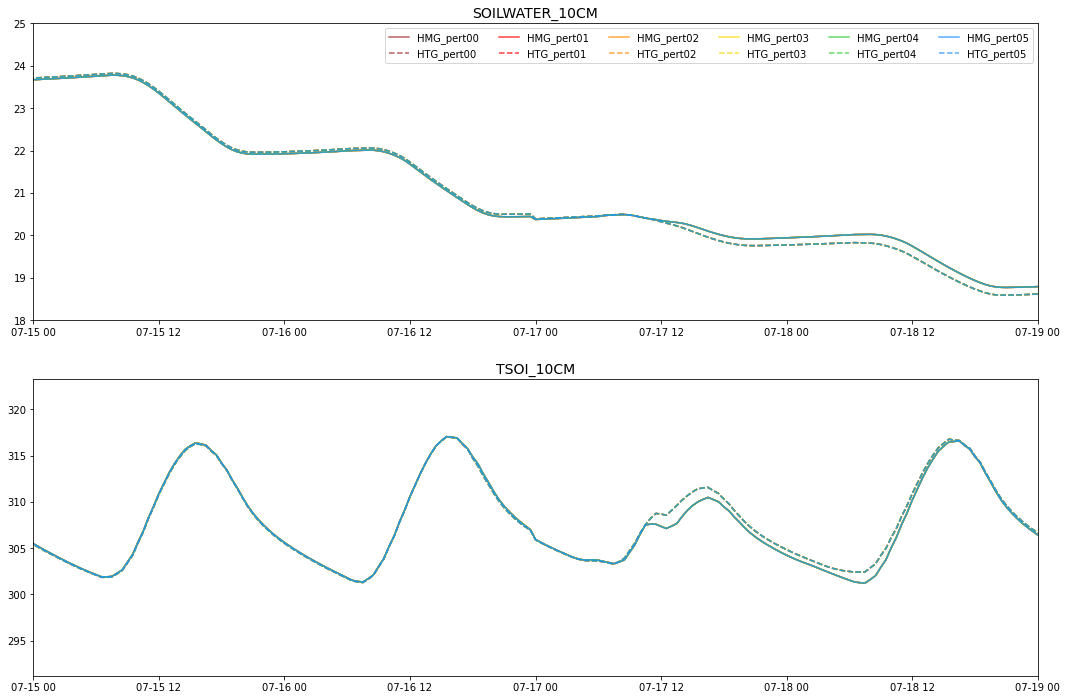

In [72]:
# Plot raw timeseries (based on afternoon mean values, so it's a bit more clear) 
plotVars = np.asarray(['SOILWATER_10CM','TSOI_10CM'])
nPlots = len(plotVars)

## Plot option for HMG/HTG lines 
pltTimeseries_HMG = True 
pltTimeseries_HTG = True 

fig,axs = plt.subplots(nPlots,1, figsize=(18,6*nPlots))
axs     = axs.ravel()

for iPlot in range(nPlots):
    
    real_varHMG      = realSfcHMGclm_upsample[plotVars[iPlot]]
    real_varHTG      = realSfcHTGclm_upsample[plotVars[iPlot]]
    ens_var          = ensCasesCLM[plotVars[iPlot]]

    timeArr = real_varHMG.time.values
    
    ## Plot lines 
    if pltTimeseries_HMG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHMG.isel(pertlim=np.where(real_varHMG.pertlim.values==0)[0]).values), 
                        color='brown', linestyle='-', alpha=0.75, label='HMG_pert00')
    if pltTimeseries_HTG:
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHTG.isel(pertlim=np.where(real_varHTG.pertlim.values==0)[0]).values), 
                        color='brown', linestyle='--', alpha=0.75, label='HTG_pert00')
        
    if pltTimeseries_HMG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHMG.isel(pertlim=np.where(real_varHMG.pertlim.values==1)[0]).values), 
                        color='red', linestyle='-', alpha=0.75, label='HMG_pert01')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHTG.isel(pertlim=np.where(real_varHTG.pertlim.values==1)[0]).values), 
                        color='red', linestyle='--', alpha=0.75, label='HTG_pert01')
        
    if pltTimeseries_HMG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHMG.isel(pertlim=2).values), 
                        color='darkorange', linestyle='-', alpha=0.75, label='HMG_pert02')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHTG.isel(pertlim=2).values), 
                        color='darkorange', linestyle='--', alpha=0.75, label='HTG_pert02')
        
    if pltTimeseries_HMG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHMG.isel(pertlim=3).values), 
                        color='gold', linestyle='-', alpha=0.75, label='HMG_pert03')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHTG.isel(pertlim=3).values), 
                        color='gold', linestyle='--', alpha=0.75, label='HTG_pert03')

    if pltTimeseries_HMG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHMG.isel(pertlim=4).values), 
                        color='limegreen', linestyle='-', alpha=0.75, label='HMG_pert04')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHTG.isel(pertlim=4).values), 
                        color='limegreen', linestyle='--', alpha=0.75, label='HTG_pert04')
        
    if pltTimeseries_HMG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHMG.isel(pertlim=5).values), 
                        color='dodgerblue', linestyle='-', alpha=0.75, label='HMG_pert05')
    if pltTimeseries_HTG: 
        axs[iPlot].plot(timeArr, 
                        np.squeeze(real_varHTG.isel(pertlim=5).values), 
                        color='dodgerblue', linestyle='--', alpha=0.75, label='HTG_pert05')

     
    ## Add separating lines for ease of looking at these 
    # axs[iPlot].axhline(0,color='k',linestyle='--')
    for iYr in range(len(yrStart)):
        axs[iPlot].axvline(yrStart[iYr], color='k',linestyle='--')
        
    # # Plot markers for days that qualify as high/low changes
    # axs[iPlot].plot(strDates[listHigh_real], np.squeeze(HMGensMean)[listHigh_real],'k^',markersize=9,alpha=0.6, label='HighDay')
    # axs[iPlot].plot(strDates[listLow_real],  np.squeeze(HMGensMean)[listLow_real],'kv',markersize=9,alpha=0.6, label='LowDay')

        
    
    
    # Add labels
    axs[iPlot].set_title(plotVars[iPlot],fontsize=14)

    ## Set a few axis limits as needed
    # axs[iPlot].set_xlim([0,88])
    # axs[iPlot].set_ylim([-1500, 1500])
    
    # # Control tick labels
    # xTicks       = axs[iPlot].get_xticks()
    # dates_xticks = strDates[xTicks.astype(int)[:-2]]
    # axs[iPlot].set_xticklabels(dates_xticks)
    
    axs[iPlot].set_xlim([datetime.date(2015,7,15), datetime.date(2015,7,19)])

axs[0].legend(ncol=6)
axs[0].set_ylim([18,25])

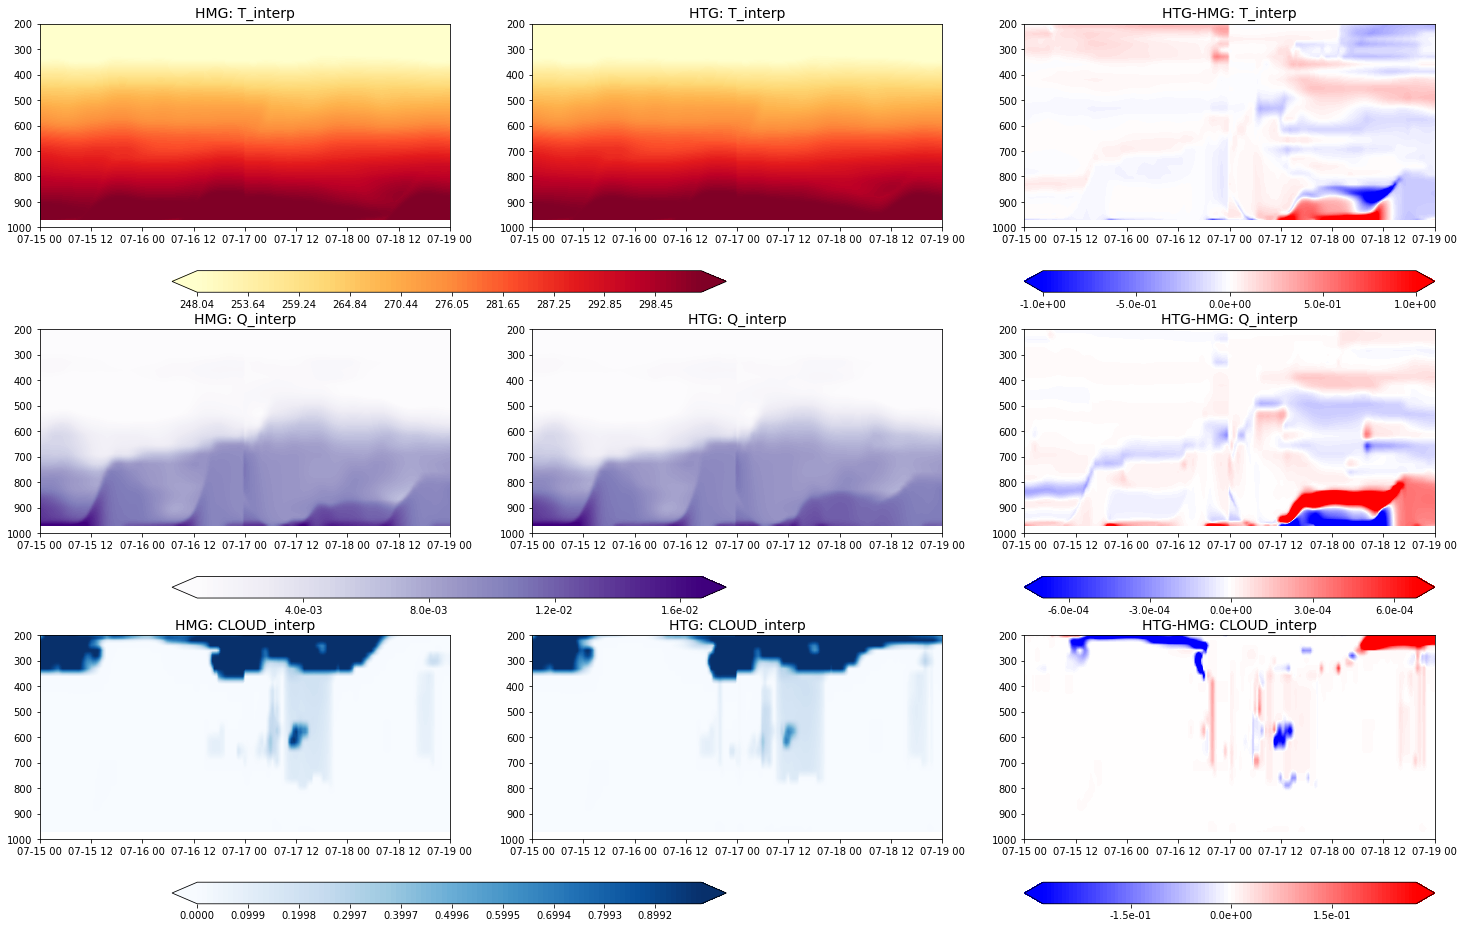

In [63]:
# Plot timeseries in the vertical

plotVars = np.asarray(['T_interp','Q_interp','CLOUD_interp'])

cmapSel  = ['YlOrRd','Purples','Blues']

nPlots   = len(plotVars)

pertSel  = 0

fig,axs = plt.subplots(nPlots,3, figsize=(25,5*nPlots))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.5)

nPlot   = 0
for iPlot in range(nPlots):
    
    real_varHMG      = realSfcHMG_upsample[plotVars[iPlot]].isel(pertlim=np.where(real_varHMG.pertlim.values==pertSel)[0])
    real_varHTG      = realSfcHTG_upsample[plotVars[iPlot]].isel(pertlim=np.where(real_varHTG.pertlim.values==pertSel)[0])
    ens_var          = ensCases[plotVars[iPlot]]
    
    diffHTG      = real_varHTG.values - real_varHMG.values

    timeArr = real_varHMG.time.values
    
    if np.shape(realSfcHMG_upsample[plotVars[iPlot]])[2]==64:
        levArr = realSfcHMG_upsample.lev.values 
    elif np.shape(realSfcHMG_upsample[plotVars[iPlot]])[2]==65:
        levArr = realSfcHMG_upsample.ilev.values 
    elif np.shape(realSfcHMG_upsample[plotVars[iPlot]])[2]==78:
        levArr = realSfcHMG_upsample.levInterp.values 
        
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -     
    ## Plot HMG and HTG cases 
    levsRaw_min = np.nanmin([np.nanpercentile(real_varHMG, 20), np.nanpercentile(real_varHTG, 20)])
    levsRaw_max = np.nanmin([np.nanpercentile(real_varHMG, 98), np.nanpercentile(real_varHTG, 98)])
    levsRaw     = np.arange(levsRaw_min, levsRaw_max, (np.abs(levsRaw_max) - np.abs(levsRaw_min))/100.0)
    
    cplot = axs[nPlot].contourf(timeArr, levArr, np.squeeze(real_varHMG).transpose(), 
                levsRaw, cmap=cmapSel[iPlot], extend='both')
    
    cplot = axs[nPlot+1].contourf(timeArr, levArr, np.squeeze(real_varHTG).transpose(), 
                levsRaw, cmap=cmapSel[iPlot], extend='both')
    
    # Add colorbar
    ax_position = axs[nPlot+1].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.06, ax_position.width+0.08, 0.02])
    if ((plotVars[iPlot]=='Q') | (plotVars[iPlot]=='Q_interp')):
        cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax,format='%.1e')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
    else:
        cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
        
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - 
    ## Plot diff
    levsDiff_min = np.nanpercentile(diffHTG, 1)
    levsDiff_max = np.nanpercentile(diffHTG, 99)
    levsDiff_evn = np.nanmax([np.abs(levsDiff_min), np.abs(levsDiff_max)])
    levsDiff     = np.arange(-levsDiff_evn, levsDiff_evn, (2*levsDiff_evn)/100.0)
    
    
    cplot = axs[nPlot+2].contourf(timeArr, levArr, np.squeeze(diffHTG).transpose(), 
                levsDiff, cmap='bwr', extend='both')
    
    # Add colorbar
    ax_position = axs[nPlot+2].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.06, ax_position.width, 0.02])
    # if ((plotVars[iPlot]=='Q') | (plotVars[iPlot]=='Q_interp')):
    cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax,format='%.1e')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # else:
    #     cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax,format='%.1e')
        
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # Add labels
    axs[nPlot+0].set_title('HMG: '+plotVars[iPlot],fontsize=14)
    axs[nPlot+1].set_title('HTG: '+plotVars[iPlot],fontsize=14)
    axs[nPlot+2].set_title('HTG-HMG: '+plotVars[iPlot],fontsize=14)

    axs[nPlot+0].set_xlim([datetime.date(2015,7,15), datetime.date(2015,7,19)])
    axs[nPlot+1].set_xlim([datetime.date(2015,7,15), datetime.date(2015,7,19)])
    axs[nPlot+2].set_xlim([datetime.date(2015,7,15), datetime.date(2015,7,19)])
    
    axs[nPlot+0].invert_yaxis()
    axs[nPlot+1].invert_yaxis()
    axs[nPlot+2].invert_yaxis()
    
    axs[nPlot+0].set_ylim([1000,200])
    axs[nPlot+1].set_ylim([1000,200])
    axs[nPlot+2].set_ylim([1000,200])
    
    nPlot = nPlot+3


    

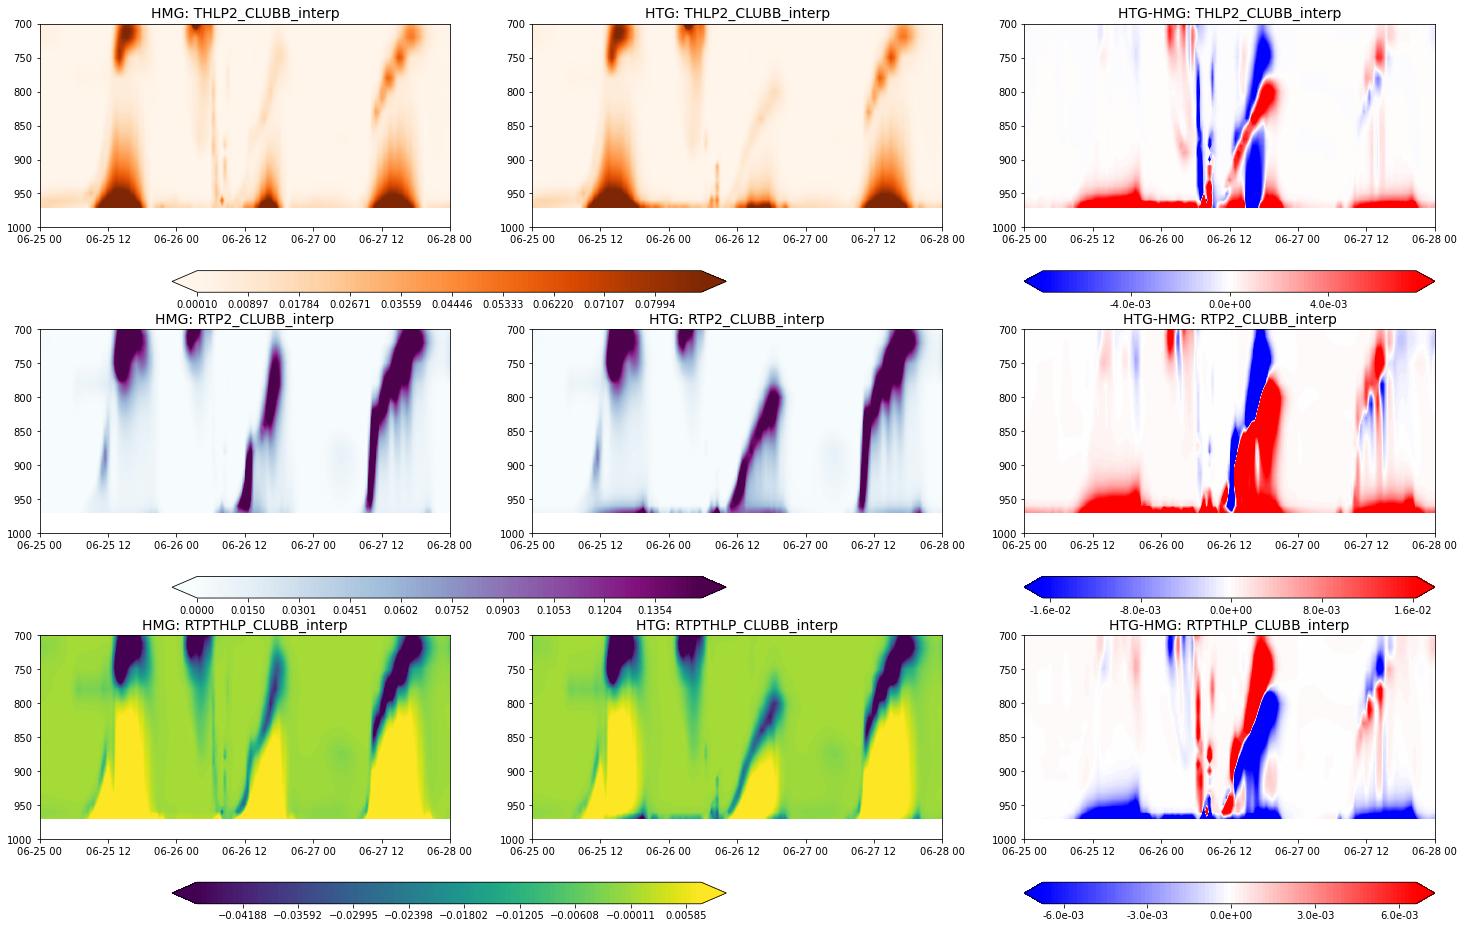

In [22]:
# Plot timeseries in the vertical

plotVars = np.asarray(['THLP2_CLUBB_interp','RTP2_CLUBB_interp','RTPTHLP_CLUBB_interp'])
cmapSel  = ['Oranges','BuPu','viridis']

nPlots   = len(plotVars)

pertSel  = 0

fig,axs = plt.subplots(nPlots,3, figsize=(25,5*nPlots))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.5)

nPlot   = 0
for iPlot in range(nPlots):
    
    real_varHMG      = realSfcHMG_upsample[plotVars[iPlot]].isel(pertlim=np.where(realSfcHMG_upsample.pertlim.values==pertSel)[0])
    real_varHTG      = realSfcHTG_upsample[plotVars[iPlot]].isel(pertlim=np.where(realSfcHTG_upsample.pertlim.values==pertSel)[0])
    ens_var          = ensCases[plotVars[iPlot]]
    
    diffHTG      = real_varHTG.values - real_varHMG.values

    timeArr = real_varHMG.time.values
    
    if np.shape(realSfcHMG_upsample[plotVars[iPlot]])[2]==64:
        levArr = realSfcHMG_upsample.lev.values 
    elif np.shape(realSfcHMG_upsample[plotVars[iPlot]])[2]==65:
        levArr = realSfcHMG_upsample.ilev.values 
    elif np.shape(realSfcHMG_upsample[plotVars[iPlot]])[2]==78:
        levArr = realSfcHMG_upsample.levInterp.values 
        
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -     
    ## Plot HMG and HTG cases 
    levsRaw_min = np.nanmin([np.nanpercentile(real_varHMG, 3), np.nanpercentile(real_varHTG, 3)])
    levsRaw_max = np.nanmin([np.nanpercentile(real_varHMG, 98), np.nanpercentile(real_varHTG, 98)])
    levsRaw     = np.arange(levsRaw_min, levsRaw_max, (levsRaw_max - levsRaw_min)/100.0)
    
    cplot = axs[nPlot].contourf(timeArr, levArr, np.squeeze(real_varHMG).transpose(), 
                levsRaw, cmap=cmapSel[iPlot], extend='both')
    
    cplot = axs[nPlot+1].contourf(timeArr, levArr, np.squeeze(real_varHTG).transpose(), 
                levsRaw, cmap=cmapSel[iPlot], extend='both')
    
    # Add colorbar
    ax_position = axs[nPlot+1].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.06, ax_position.width+0.08, 0.02])
    if ((plotVars[iPlot]=='Q') | (plotVars[iPlot]=='Q_interp')):
        cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax,format='%.1e')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
    else:
        cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
        
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - 
    ## Plot diff
    levsDiff_min = np.nanpercentile(diffHTG, 3)
    levsDiff_max = np.nanpercentile(diffHTG, 97)
    levsDiff_evn = np.nanmax([np.abs(levsDiff_min), np.abs(levsDiff_max)])
    levsDiff     = np.arange(-levsDiff_evn, levsDiff_evn, (2*levsDiff_evn)/100.0)
    
    
    cplot = axs[nPlot+2].contourf(timeArr, levArr, np.squeeze(diffHTG).transpose(), 
                levsDiff, cmap='bwr', extend='both')
    
    # Add colorbar
    ax_position = axs[nPlot+2].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.06, ax_position.width, 0.02])
    # if ((plotVars[iPlot]=='Q') | (plotVars[iPlot]=='Q_interp')):
    cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax,format='%.1e')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # else:
    #     cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax,format='%.1e')
        
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # Add labels
    axs[nPlot+0].set_title('HMG: '+plotVars[iPlot],fontsize=14)
    axs[nPlot+1].set_title('HTG: '+plotVars[iPlot],fontsize=14)
    axs[nPlot+2].set_title('HTG-HMG: '+plotVars[iPlot],fontsize=14)

    axs[nPlot+0].set_xlim([datetime.date(2015,6,25), datetime.date(2015,6,28)])
    axs[nPlot+1].set_xlim([datetime.date(2015,6,25), datetime.date(2015,6,28)])
    axs[nPlot+2].set_xlim([datetime.date(2015,6,25), datetime.date(2015,6,28)])
    
    axs[nPlot+0].invert_yaxis()
    axs[nPlot+1].invert_yaxis()
    axs[nPlot+2].invert_yaxis()
    
    axs[nPlot+0].set_ylim([1000,700])
    axs[nPlot+1].set_ylim([1000,700])
    axs[nPlot+2].set_ylim([1000,700])
    
    nPlot = nPlot+3


    

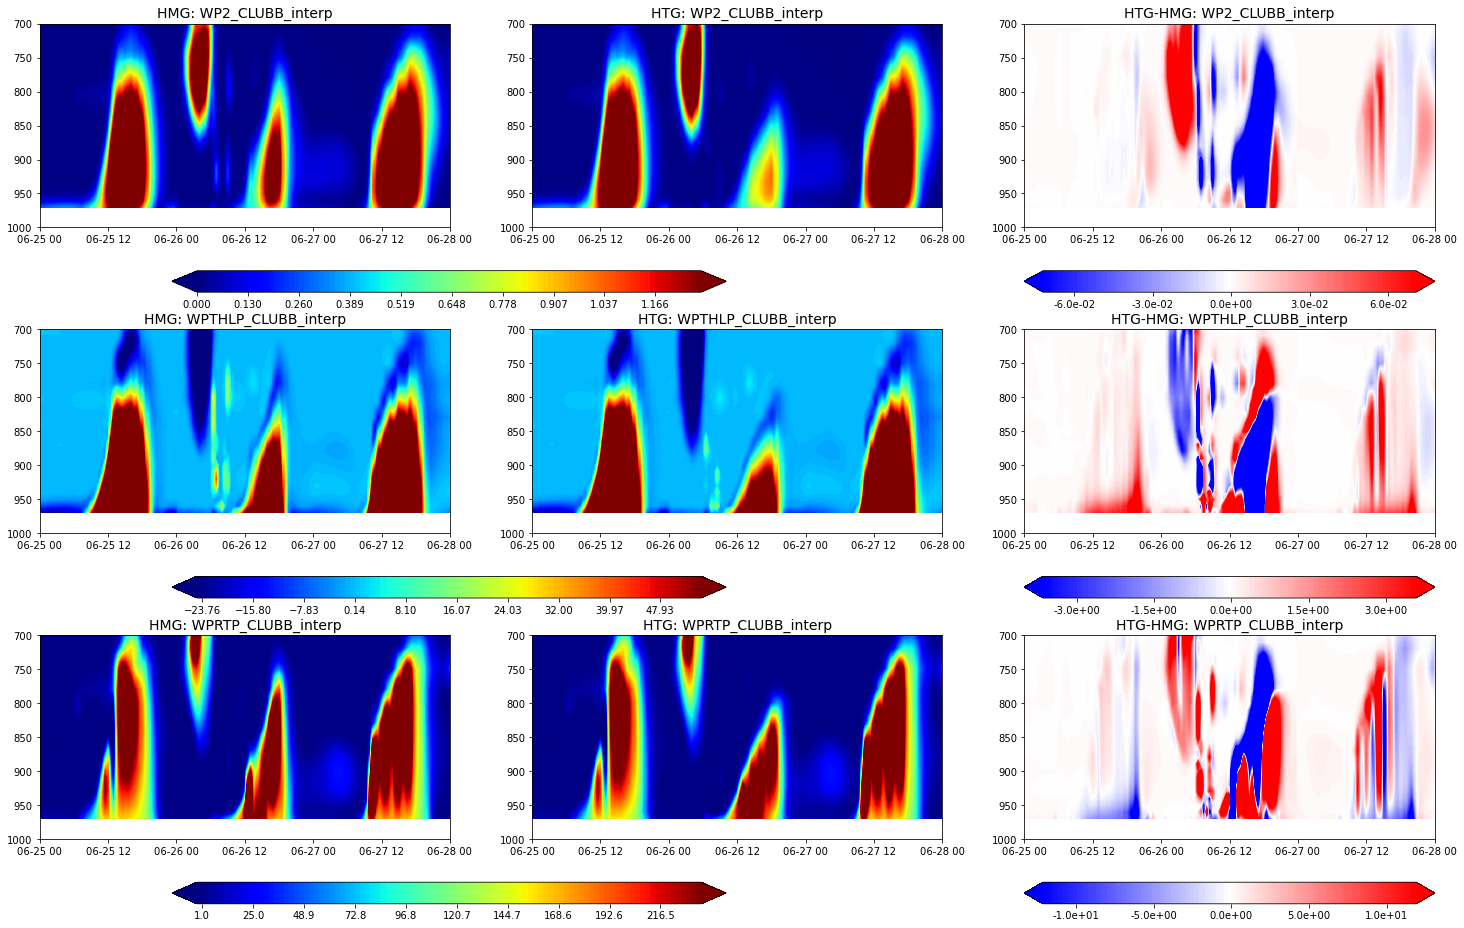

In [25]:
# Plot timeseries in the vertical

plotVars = np.asarray(['WP2_CLUBB_interp','WPTHLP_CLUBB_interp','WPRTP_CLUBB_interp'])

nPlots   = len(plotVars)

pertSel  = 0

fig,axs = plt.subplots(nPlots,3, figsize=(25,5*nPlots))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.5)

nPlot   = 0
for iPlot in range(nPlots):
    
    real_varHMG      = realSfcHMG_upsample[plotVars[iPlot]].isel(pertlim=np.where(realSfcHMG_upsample.pertlim.values==pertSel)[0])
    real_varHTG      = realSfcHTG_upsample[plotVars[iPlot]].isel(pertlim=np.where(realSfcHTG_upsample.pertlim.values==pertSel)[0])
    ens_var          = ensCases[plotVars[iPlot]]
    
    diffHTG      = real_varHTG.values - real_varHMG.values

    timeArr = real_varHMG.time.values
    
    if np.shape(realSfcHMG_upsample[plotVars[iPlot]])[2]==64:
        levArr = realSfcHMG_upsample.lev.values 
    elif np.shape(realSfcHMG_upsample[plotVars[iPlot]])[2]==65:
        levArr = realSfcHMG_upsample.ilev.values 
    elif np.shape(realSfcHMG_upsample[plotVars[iPlot]])[2]==78:
        levArr = realSfcHMG_upsample.levInterp.values 
        
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -     
    ## Plot HMG and HTG cases 
    levsRaw_min = np.nanmin([np.nanpercentile(real_varHMG, 2), np.nanpercentile(real_varHTG, 2)])
    levsRaw_max = np.nanmin([np.nanpercentile(real_varHMG, 98), np.nanpercentile(real_varHTG, 98)])
    levsRaw     = np.arange(levsRaw_min, levsRaw_max, (levsRaw_max - levsRaw_min)/100.0)
    
    cplot = axs[nPlot].contourf(timeArr, levArr, np.squeeze(real_varHMG).transpose(), 
                levsRaw, cmap='jet', extend='both')
    
    cplot = axs[nPlot+1].contourf(timeArr, levArr, np.squeeze(real_varHTG).transpose(), 
                levsRaw, cmap='jet', extend='both')
    
    # Add colorbar
    ax_position = axs[nPlot+1].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.06, ax_position.width+0.08, 0.02])
    if ((plotVars[iPlot]=='Q') | (plotVars[iPlot]=='Q_interp')):
        cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax,format='%.1e')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
    else:
        cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
        
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - 
    ## Plot diff
    levsDiff_min = np.nanpercentile(diffHTG, 3)
    levsDiff_max = np.nanpercentile(diffHTG, 97)
    levsDiff_evn = np.nanmax([np.abs(levsDiff_min), np.abs(levsDiff_max)])
    levsDiff     = np.arange(-levsDiff_evn, levsDiff_evn, (2*levsDiff_evn)/100.0)
    
    
    cplot = axs[nPlot+2].contourf(timeArr, levArr, np.squeeze(diffHTG).transpose(), 
                levsDiff, cmap='bwr', extend='both')
    
    # Add colorbar
    ax_position = axs[nPlot+2].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.06, ax_position.width, 0.02])
    # if ((plotVars[iPlot]=='Q') | (plotVars[iPlot]=='Q_interp')):
    cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax,format='%.1e')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # else:
    #     cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax,format='%.1e')
        
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # Add labels
    axs[nPlot+0].set_title('HMG: '+plotVars[iPlot],fontsize=14)
    axs[nPlot+1].set_title('HTG: '+plotVars[iPlot],fontsize=14)
    axs[nPlot+2].set_title('HTG-HMG: '+plotVars[iPlot],fontsize=14)

    axs[nPlot+0].set_xlim([datetime.date(2015,6,25), datetime.date(2015,6,28)])
    axs[nPlot+1].set_xlim([datetime.date(2015,6,25), datetime.date(2015,6,28)])
    axs[nPlot+2].set_xlim([datetime.date(2015,6,25), datetime.date(2015,6,28)])
    
    axs[nPlot+0].invert_yaxis()
    axs[nPlot+1].invert_yaxis()
    axs[nPlot+2].invert_yaxis()
    
    axs[nPlot+0].set_ylim([1000,700])
    axs[nPlot+1].set_ylim([1000,700])
    axs[nPlot+2].set_ylim([1000,700])
    
    nPlot = nPlot+3


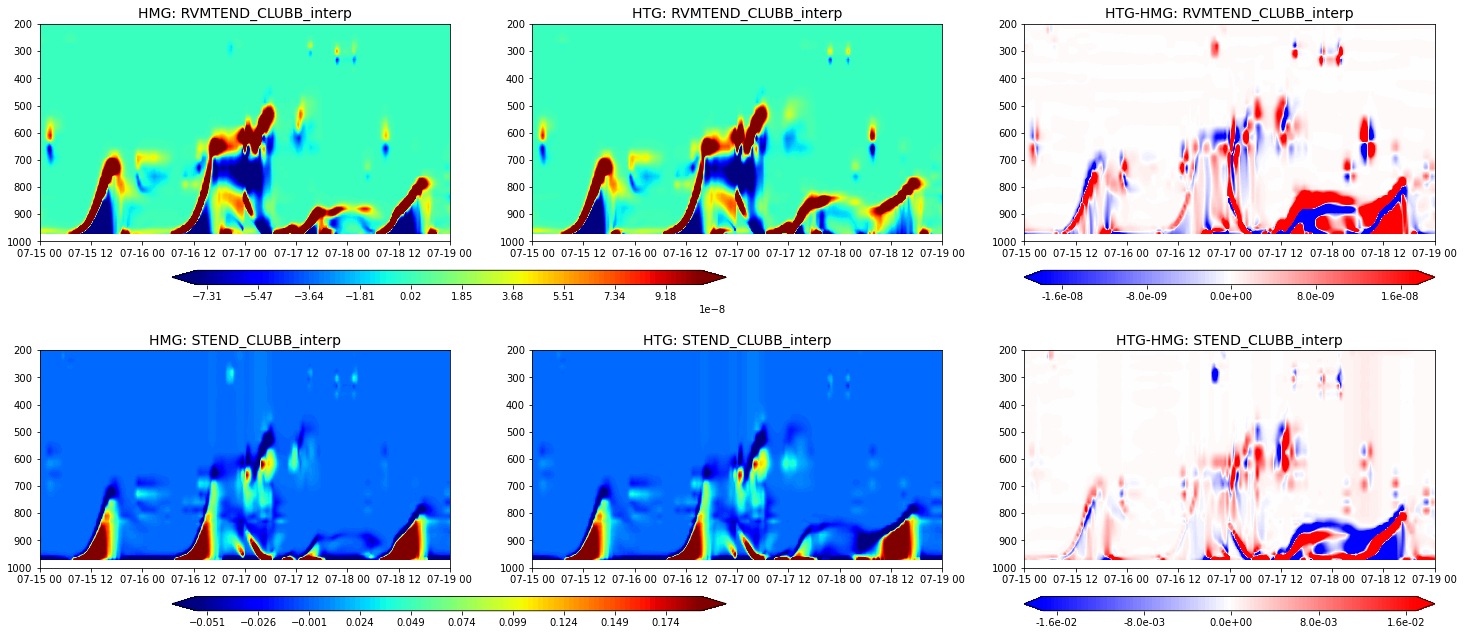

In [24]:
# Plot timeseries in the vertical

plotVars = np.asarray(['RVMTEND_CLUBB_interp','STEND_CLUBB_interp'])

nPlots   = len(plotVars)

pertSel  = 0

fig,axs = plt.subplots(nPlots,3, figsize=(25,5*nPlots))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.5)

nPlot   = 0
for iPlot in range(nPlots):
    
    real_varHMG      = realSfcHMG_upsample[plotVars[iPlot]].isel(pertlim=np.where(real_varHMG.pertlim.values==pertSel)[0])
    real_varHTG      = realSfcHTG_upsample[plotVars[iPlot]].isel(pertlim=np.where(real_varHTG.pertlim.values==pertSel)[0])
    ens_var          = ensCases[plotVars[iPlot]]
    
    diffHTG      = real_varHTG.values - real_varHMG.values

    timeArr = real_varHMG.time.values
    
    if np.shape(realSfcHMG_upsample[plotVars[iPlot]])[2]==64:
        levArr = realSfcHMG_upsample.lev.values 
    elif np.shape(realSfcHMG_upsample[plotVars[iPlot]])[2]==65:
        levArr = realSfcHMG_upsample.ilev.values 
    elif np.shape(realSfcHMG_upsample[plotVars[iPlot]])[2]==78:
        levArr = realSfcHMG_upsample.levInterp.values 
        
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -     
    ## Plot HMG and HTG cases 
    levsRaw_min = np.nanmin([np.nanpercentile(real_varHMG, 2), np.nanpercentile(real_varHTG, 2)])
    levsRaw_max = np.nanmin([np.nanpercentile(real_varHMG, 98), np.nanpercentile(real_varHTG, 98)])
    levsRaw     = np.arange(levsRaw_min, levsRaw_max, (levsRaw_max - levsRaw_min)/100.0)
    
    cplot = axs[nPlot].contourf(timeArr, levArr, np.squeeze(real_varHMG).transpose(), 
                levsRaw, cmap='jet', extend='both')
    
    cplot = axs[nPlot+1].contourf(timeArr, levArr, np.squeeze(real_varHTG).transpose(), 
                levsRaw, cmap='jet', extend='both')
    
    # Add colorbar
    ax_position = axs[nPlot+1].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.06, ax_position.width+0.08, 0.02])
    if ((plotVars[iPlot]=='Q') | (plotVars[iPlot]=='Q_interp')):
        cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax,format='%.1e')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
    else:
        cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
        
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - 
    ## Plot diff
    levsDiff_min = np.nanpercentile(diffHTG, 3)
    levsDiff_max = np.nanpercentile(diffHTG, 97)
    levsDiff_evn = np.nanmax([np.abs(levsDiff_min), np.abs(levsDiff_max)])
    levsDiff     = np.arange(-levsDiff_evn, levsDiff_evn, (2*levsDiff_evn)/100.0)
    
    
    cplot = axs[nPlot+2].contourf(timeArr, levArr, np.squeeze(diffHTG).transpose(), 
                levsDiff, cmap='bwr', extend='both')
    
    # Add colorbar
    ax_position = axs[nPlot+2].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.06, ax_position.width, 0.02])
    # if ((plotVars[iPlot]=='Q') | (plotVars[iPlot]=='Q_interp')):
    cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax,format='%.1e')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # else:
    #     cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax,format='%.1e')
        
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -   
    # Add labels
    axs[nPlot+0].set_title('HMG: '+plotVars[iPlot],fontsize=14)
    axs[nPlot+1].set_title('HTG: '+plotVars[iPlot],fontsize=14)
    axs[nPlot+2].set_title('HTG-HMG: '+plotVars[iPlot],fontsize=14)

    axs[nPlot+0].set_xlim([datetime.date(2015,7,15), datetime.date(2015,7,19)])
    axs[nPlot+1].set_xlim([datetime.date(2015,7,15), datetime.date(2015,7,19)])
    axs[nPlot+2].set_xlim([datetime.date(2015,7,15), datetime.date(2015,7,19)])
    
    axs[nPlot+0].invert_yaxis()
    axs[nPlot+1].invert_yaxis()
    axs[nPlot+2].invert_yaxis()
    
    axs[nPlot+0].set_ylim([1000,200])
    axs[nPlot+1].set_ylim([1000,200])
    axs[nPlot+2].set_ylim([1000,200])
    
    nPlot = nPlot+3


## New way of looking at sensitive days

In [26]:
botLev = 960
topLev = 800

startHr = 12 
endHr   = 18 

iHours = np.where( (realSfcHMG_upsample['time.hour']>=startHr) & (realSfcHMG_upsample['time.hour']<=endHr) )[0]
iLevs  = np.where( (realSfcHTG_upsample['levInterp']<=botLev)  & (realSfcHTG_upsample['levInterp']>=topLev))[0]

# For each date, get the mean value over the selected time period 
# ensHMG_sel = ensHMG.isel(time=iHours, levInterp=iLevs)
# ensHTG_sel = ensHTG.isel(time=iHours, levInterp=iLevs)

ensHMG_sel = realSfcHMG_upsample.isel(time=iHours)
ensHTG_sel = realSfcHTG_upsample.isel(time=iHours)

## Get mean over each day at these levels
ensHMG_sel_dayMean    = ensHMG_sel.groupby('year_month_day').mean(dim=['time','levInterp'])
ensHTG_sel_dayMean    = ensHTG_sel.groupby('year_month_day').mean(dim=['time','levInterp'])



In [28]:
## Get ens mean
ensHMG_sel_ensMean = ensHMG_sel_dayMean.groupby('year_month_day').mean(dim=['pertlim'])
ensHTG_sel_ensMean = ensHTG_sel_dayMean.groupby('year_month_day').mean(dim=['pertlim'])


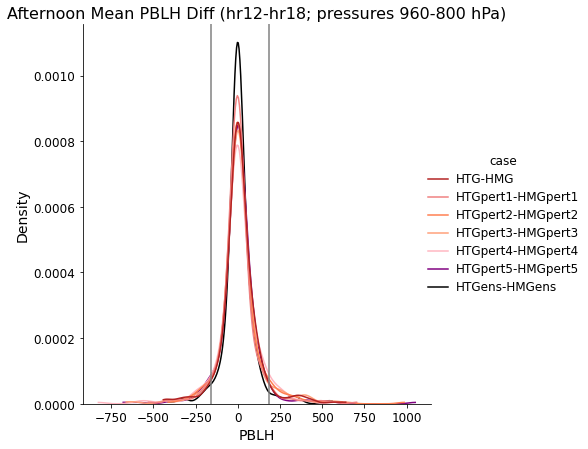

In [29]:
# varSel = 'THLP2_CLUBB_interp'
varSel = 'PBLH'

diffHTG_mean = ensHTG_sel_ensMean[varSel] - ensHMG_sel_ensMean[varSel]


## Get differences per ensemble 
ensHMG_var = ensHMG_sel_dayMean[varSel]
ensHTG_var = ensHTG_sel_dayMean[varSel]

diffHTG_pert00 = ensHTG_var.isel(pertlim=np.where(ensHTG_var.pertlim.values==0)[0]).values-ensHMG_var.isel(pertlim=np.where(ensHMG_var.pertlim.values==0)[0]).values
diffHTG_pert01 = ensHTG_var.isel(pertlim=np.where(ensHTG_var.pertlim.values==1)[0]).values-ensHMG_var.isel(pertlim=np.where(ensHMG_var.pertlim.values==1)[0]).values
diffHTG_pert02 = ensHTG_var.isel(pertlim=np.where(ensHTG_var.pertlim.values==2)[0]).values-ensHMG_var.isel(pertlim=np.where(ensHMG_var.pertlim.values==2)[0]).values
diffHTG_pert03 = ensHTG_var.isel(pertlim=np.where(ensHTG_var.pertlim.values==3)[0]).values-ensHMG_var.isel(pertlim=np.where(ensHMG_var.pertlim.values==3)[0]).values
diffHTG_pert04 = ensHTG_var.isel(pertlim=np.where(ensHTG_var.pertlim.values==4)[0]).values-ensHMG_var.isel(pertlim=np.where(ensHMG_var.pertlim.values==4)[0]).values
diffHTG_pert05 = ensHTG_var.isel(pertlim=np.where(ensHTG_var.pertlim.values==5)[0]).values-ensHMG_var.isel(pertlim=np.where(ensHMG_var.pertlim.values==5)[0]).values


# Define dataframe
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
     pd.DataFrame.from_dict({varSel: np.squeeze(diffHTG_pert00),          'case': 'HTG-HMG'}), 
     pd.DataFrame.from_dict({varSel: np.squeeze(diffHTG_pert01),          'case': 'HTGpert1-HMGpert1'}),
     pd.DataFrame.from_dict({varSel: np.squeeze(diffHTG_pert02),          'case': 'HTGpert2-HMGpert2'}),
     pd.DataFrame.from_dict({varSel: np.squeeze(diffHTG_pert03),          'case': 'HTGpert3-HMGpert3'}),
     pd.DataFrame.from_dict({varSel: np.squeeze(diffHTG_pert04),          'case': 'HTGpert4-HMGpert4'}),
     pd.DataFrame.from_dict({varSel: np.squeeze(diffHTG_pert05),          'case': 'HTGpert5-HMGpert5'}), 
     pd.DataFrame.from_dict({varSel: np.squeeze(diffHTG_mean),            'case': 'HTGens-HMGens'}), 
])

# Make plot 
g = sns.displot(dfReal, x=varSel, hue='case', kind='kde', height=6, cut=0, 
                palette=['firebrick','lightcoral','coral','lightsalmon','lightpink','purple','k'])

g.ax.set_title("Afternoon Mean "+varSel+" Diff (hr"+str(startHr)+"-hr"+str(endHr)+"; pressures "+str(botLev)+"-"+str(topLev)+" hPa)", fontsize=16 ) 
g.ax.set_xlabel(varSel,fontsize=14)
g.ax.set_ylabel('Density',fontsize=14)
g.ax.tick_params(axis='both', labelsize= 12)
plt.setp(g._legend.get_title(), fontsize=12)
plt.setp(g._legend.get_texts(), fontsize=12)

upperLim = np.nanpercentile(dfReal[varSel].values, 95)
lowerLim = np.nanpercentile(dfReal[varSel].values, 5)
plt.axvline(lowerLim,color='grey')
plt.axvline(upperLim,color='grey')

plt.show()
